In [1]:
#!/usr/bin/env python3
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import tinydb as db
from tinydb.storages import MemoryStorage
import matplotlib.pyplot as plt
# plt.style.use('../clint.mpl')
import matplotlib as mpl
from matplotlib.colors import LogNorm

import boost_histogram as bh
import pickle as pl

import scipy.stats as stats
import scipy.optimize as opt
from pygama import DataGroup
import pygama.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf
import cage_utils
plt.rcParams['figure.figsize'] = [14, 10]

In [2]:
run = 64 #44 #70 #64
dsp_id = '02'
user = True
hit =True
cal = True
lowE=False
etype = 'trapEftp_cal'

corr_DCR=True
corr_AoE=True
corr_ToE=True

norm = True
cut = True


dsp_list = ['energy', 'trapEftp', 'trapEmax', 'trapEftp_cal', 'bl','bl_sig', 'bl_slope', 'AoE', 'dcr', "tp_0", "tp_02", "tp_05", "tp_10", "tp_20", "tp_30", "tp_40", "tp_50", "tp_60", "tp_70", "tp_80", "tp_90", "tp_96", 'tp_max', 'ToE', 'log_tail_fit_slope', 'wf_max', 'wf_argmax', 'trapE_argmax', 'lf_max']

df_raw, dg, runtype, rt_min, radius, angle_det, rotary = cage_utils.getDataFrame(run, user=user, hit=hit, cal=cal, dsp_list=dsp_list, lowE=lowE)




Radius: 7.5; Angle: 90; Rotary: 0.0
user: True; cal: True; hit: True
Using hit files
loading data for /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc869_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc870_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc871_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc872_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc873_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc874_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc875_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc876_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc877_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc878_hit.lh5


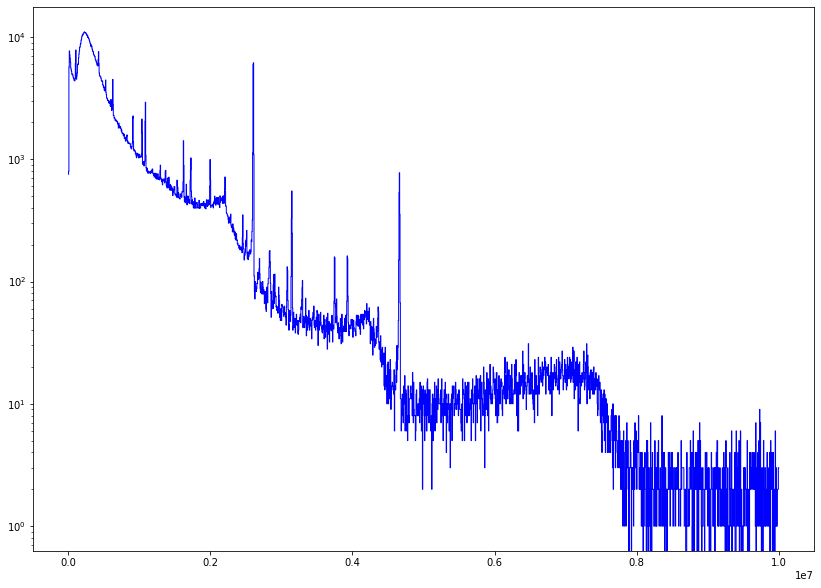

In [3]:
# Make energy spectrum
raw_elo, raw_ehi, raw_epb = 0, 10000000, 5000
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10


        

nbx = int((raw_ehi-raw_elo)/raw_epb)

raw_energy_hist, ebins = np.histogram(df_raw['energy'], bins=nbx,
                range=[raw_elo, raw_ehi])


plt.semilogy(ebins[1:], raw_energy_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'


# plt.axvline(rawE_lo, c='r', lw=1)
# plt.axvline(rawE_hi, c='r', lw=1)

# plt.xlabel(etype, ha='right', x=1)
# plt.ylabel('cts / sec', ha='right', y=1)
# # plt.legend()
# # plt.title(f'{etype}: {runtype} run {run} , {rt_min:.2f} mins')
# plt.savefig(f'./plots/normScan/{runtype}_energy_run{run}.pdf', dpi=200)
# plt.xlim(80000, 150000) 
# plt.ylim(0, 100)
plt.show()

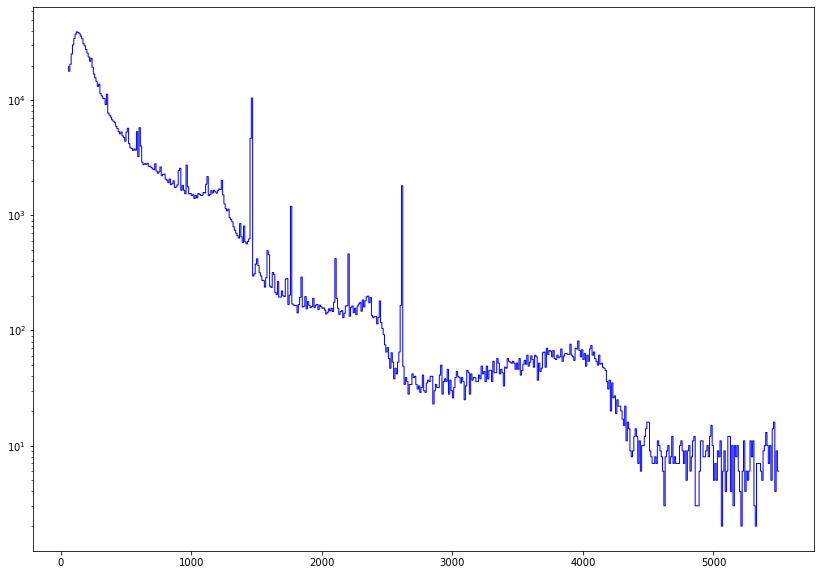

In [4]:
# Make energy spectrum
elo, ehi, epb = 50, 5500, 10
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)

energy_hist, ebins = np.histogram(df_raw['trapEftp_cal'], bins=nbx,
                range=[elo, ehi])


plt.semilogy(ebins[1:], energy_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'

# plt.xlabel(etype, ha='right', x=1)
# plt.ylabel('cts / sec', ha='right', y=1)
# # plt.legend()
# # plt.title(f'{etype}: {runtype} run {run} , {rt_min:.2f} mins')
# plt.savefig(f'./plots/normScan/{runtype}_energy_run{run}.pdf', dpi=200)
# plt.xlim(80000, 150000)
plt.show()

Muon cut

In [5]:
muon_cut = f'energy < 10000000'
df_raw = df_raw.query(muon_cut).copy()

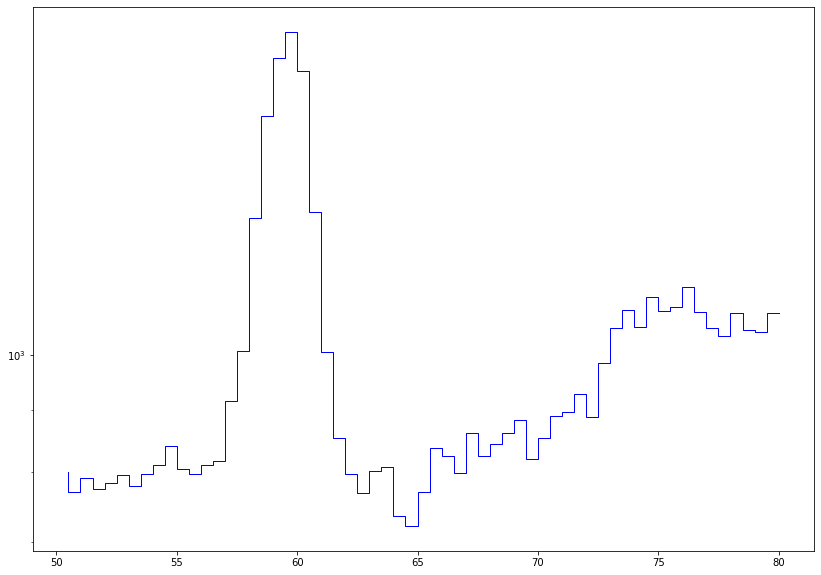

In [6]:
# Make energy spectrum
elo, ehi, epb = 50, 80, 0.5
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)

energy_hist, ebins = np.histogram(df_raw['trapEftp_cal'], bins=nbx,
                range=[elo, ehi])


plt.semilogy(ebins[1:], energy_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'

# plt.xlabel(etype, ha='right', x=1)
# plt.ylabel('cts / sec', ha='right', y=1)
# # plt.legend()
# # plt.title(f'{etype}: {runtype} run {run} , {rt_min:.2f} mins')
# plt.savefig(f'./plots/normScan/{runtype}_energy_run{run}.pdf', dpi=200)
# plt.xlim(80000, 150000)
plt.show()

mode: 59.79398597086225
width: 1.4317336102082534
amp: 824.3771623751519


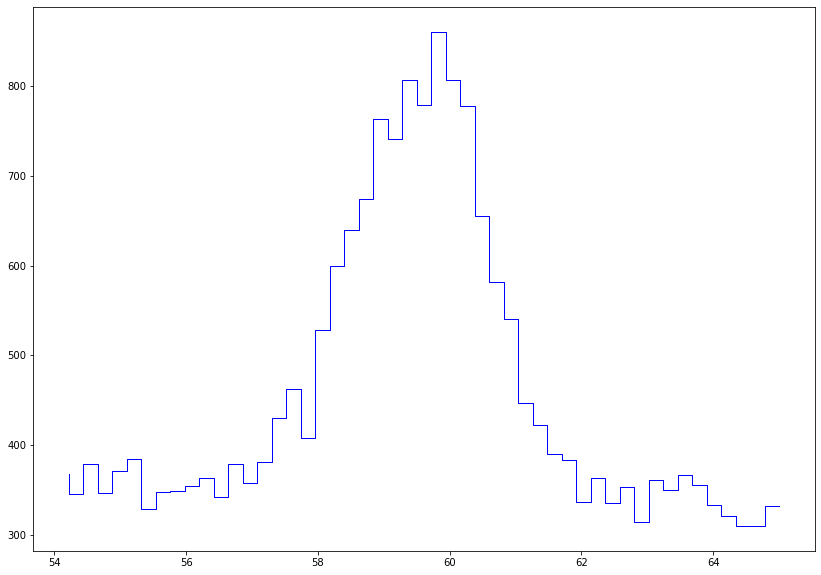

In [249]:
pgfenergy_hist, pgfebins, evars = pgh.get_hist(df_raw['trapEftp_cal'], bins=50, range=[54, 65]) #range=[54, 65]
plt.plot(pgfebins[1:], pgfenergy_hist, ds='steps', c='b', lw=1)
pars, cov = pgf.gauss_mode_width_max(pgfenergy_hist, pgfebins, evars)
mode = pars[0]
width = pars[1]
amp = pars[2]
print(f'mode: {mode}')
print(f'width: {width}')
print(f'amp: {amp}')

In [14]:
def gauss_fit_func(x, A, mu, sigma, C):
    return (A * (1/(sigma*np.sqrt(2*np.pi))) *(np.exp(-1.0 * ((x - mu)**2) / (2 * sigma**2))+C))


In [250]:
e_pars, ecov = pgf.fit_hist(gauss_fit_func, pgfenergy_hist, pgfebins, evars, guess = (amp, mode, width, 1))

mean_fit = e_pars[1]
width_fit = e_pars[2]
amp_fit = e_pars[0]
const_fit = e_pars[3]

fwhm = width_fit*2.355

print(f'mean: {mean_fit}')
print(f'width: {width_fit}')
print(f'amp: {amp_fit}')
print(f'C: {const_fit}')
print(f'FWHM at 60 keV: {fwhm} \n{(fwhm/mean_fit)*100}%')

mean: 59.54116334599677
width: 1.0023540335803176
amp: 1216.0428285276714
C: 0.7125124567218665
FWHM at 60 keV: 2.360543749081648 
3.9645576546168684%


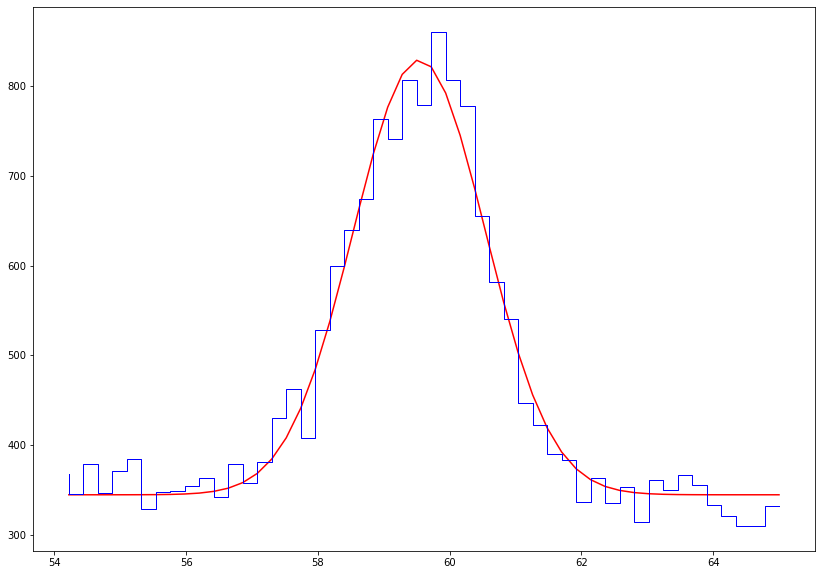

In [251]:
plt.plot(pgfebins[1:], gauss_fit_func(pgfebins[1:], *e_pars), c = 'r')
plt.plot(pgfebins[1:], pgfenergy_hist, ds='steps', c='b', lw=1)

In [86]:
df_raw = df_raw.query('wf_max<15000').copy()

<ipython-input-286-5050307f652f>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(X, Y, wf_maxVEnergy)


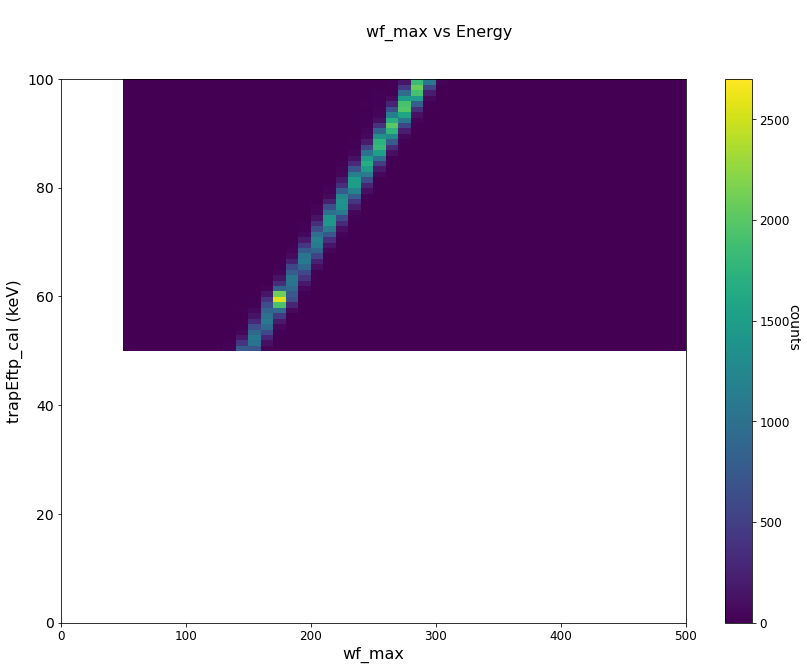

In [286]:
fig, ax = plt.subplots()
elo, ehi, epb = 50, 5500, 1
e_bins = int((ehi-elo)/epb)
wflo, wfhi = 50, 15000
wf_bins = int((wfhi - wflo )/10)
fig.suptitle(f'\nwf_max vs Energy', horizontalalignment='center', fontsize=16)
wf_maxVEnergy, xedges, yedges = np.histogram2d(df_raw['wf_max'], df_raw['trapEftp_cal'], bins=[wf_bins, e_bins], range=([wflo, wfhi], [elo, ehi]))
X, Y = np.mgrid[wflo:wfhi:wf_bins*1j, elo:ehi:e_bins*1j]

pcm = plt.pcolormesh(X, Y, wf_maxVEnergy)
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('wf_max', fontsize=16)
ax.set_ylabel('trapEftp_cal (keV)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(0, 1000)
# plt.ylim(0, 200)

plt.ylim(0, 100)
plt.xlim(0, 500)
plt.show()

In [287]:
median, xedges, binnumber = stats.binned_statistic(df_raw['wf_max'], df_raw['trapEftp_cal'], statistic = 'mean', bins = wf_bins)


en_bin_centers = pgh.get_bin_centers(xedges)

idx = np.isfinite(en_bin_centers) & np.isfinite(median)


fit_raw, cov = np.polyfit(en_bin_centers[idx], median[idx], deg=1, cov=True)

const = fit_raw[0]
offset = fit_raw[1]
err = np.sqrt(np.diag(cov))

<ipython-input-290-5734760bb637>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())


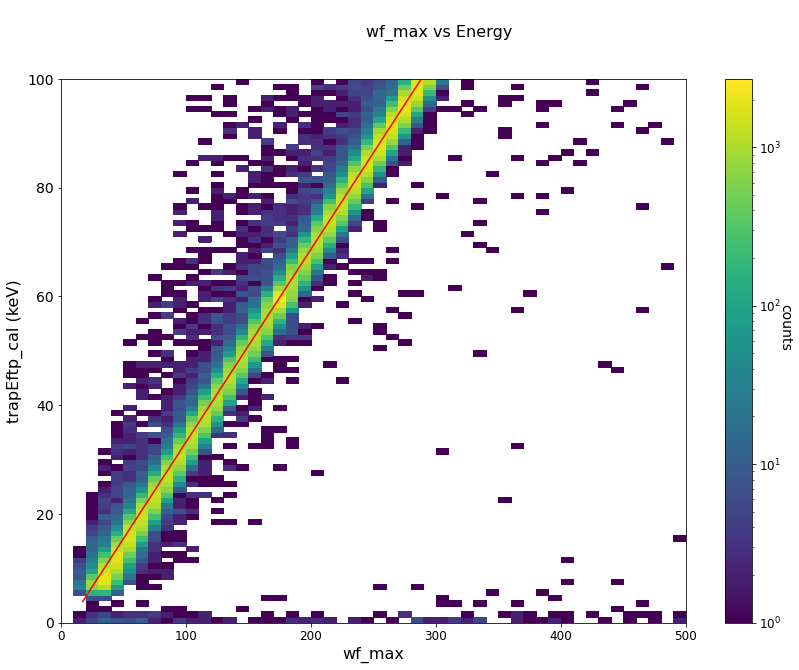

In [290]:
fig, ax = plt.subplots()
elo, ehi, epb = 0, 5500, 1
e_bins = int((ehi-elo)/epb)
wflo, wfhi = 0, 15000
wf_bins = int((wfhi - wflo )/10)
fig.suptitle(f'\nwf_max vs Energy', horizontalalignment='center', fontsize=16)
tp0Vtpmax_hist_norm, xedges, yedges = np.histogram2d(df_raw['wf_max'], df_raw['trapEftp_cal'], bins=[wf_bins, e_bins], range=([wflo, wfhi], [elo, ehi]))
X, Y = np.mgrid[wflo:wfhi:wf_bins*1j, elo:ehi:e_bins*1j]

pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('wf_max', fontsize=16)
ax.set_ylabel('trapEftp_cal (keV)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(200, 1000)
# plt.ylim(0, 400)
y = const*en_bin_centers + offset
plt.plot(en_bin_centers, y, 'r')

# plt.ylim(2000, 5000)
# plt.ylim(40, 80)
# plt.xlim(50, 500)

plt.ylim(0, 100)
plt.xlim(0, 500)
plt.show()

<ipython-input-275-9fa89b3a7130>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())


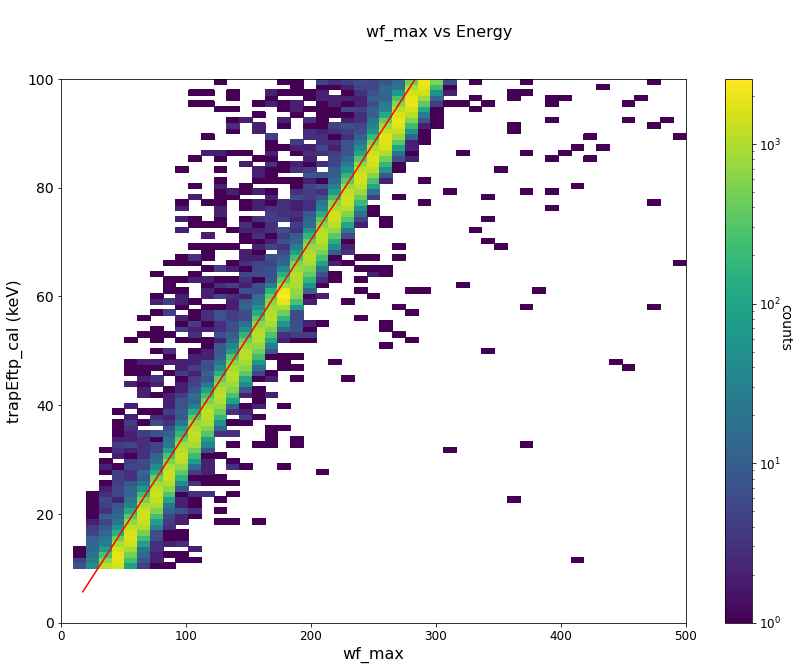

In [275]:
fig, ax = plt.subplots()
elo, ehi, epb = 10, 100, 1
e_bins = int((ehi-elo)/epb)
wflo, wfhi = 0, 500
wf_bins = int((wfhi - wflo )/10)
fig.suptitle(f'\nwf_max vs Energy', horizontalalignment='center', fontsize=16)
tp0Vtpmax_hist_norm, xedges, yedges = np.histogram2d(df_raw['wf_max'], df_raw['trapEftp_cal'], bins=[wf_bins, e_bins], range=([wflo, wfhi], [elo, ehi]))
X, Y = np.mgrid[wflo:wfhi:wf_bins*1j, elo:ehi:e_bins*1j]

pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('wf_max', fontsize=16)
ax.set_ylabel('trapEftp_cal (keV)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(200, 1000)
# plt.ylim(0, 400)
y = const*en_bin_centers + offset
plt.plot(en_bin_centers, y, 'r')

# plt.ylim(2000, 5000)
plt.ylim(0, 100)
plt.xlim(0, 500)
plt.show()

In [90]:
wf_max_cut = f'({const}*wf_max + {offset})*(1-0.04) < trapEftp_cal < ({const}*wf_max + {offset})*(1+0.04)'

df_raw_tot = len(df_raw)
cut_pass = len(df_raw.query(wf_max_cut).copy())
print(f'{cut_pass} events passing cut \n{(cut_pass/df_raw_tot)*100}%')

df= df_raw.query(wf_max_cut).copy()
# print(wf_max_cut)

1048487 events passing cut 
93.35485077284706%


Now look at parameters after basic cuts

<ipython-input-96-eb030ceb406c>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(X, Y, wf_maxVEnergy, norm=LogNorm())


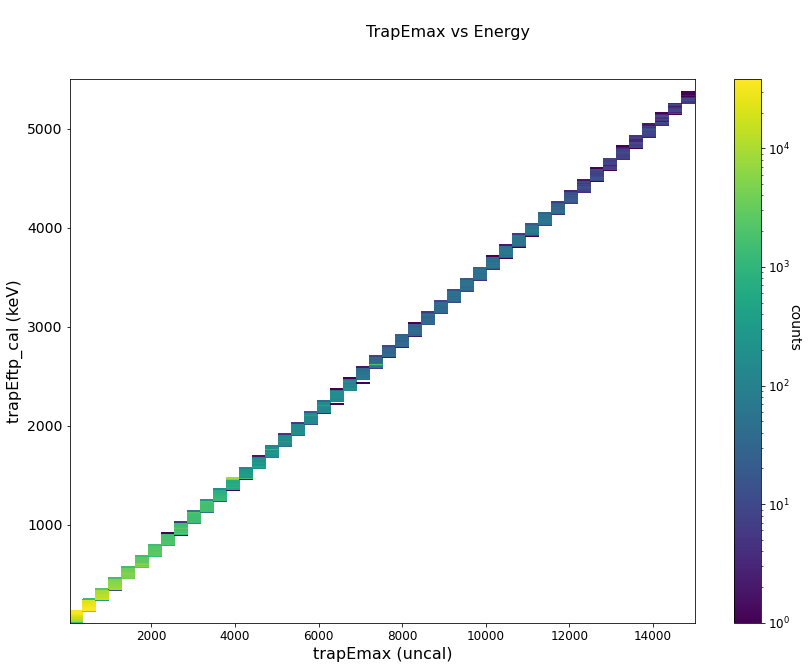

In [96]:
fig, ax = plt.subplots()
elo, ehi, epb = 10, 5500, 10
e_bins = int((ehi-elo)/epb)
trapEmax_lo, trapEmax_hi = 50, 15000
trapEmax_bins = int((wfhi - wflo )/10)
fig.suptitle(f'\nTrapEmax vs Energy', horizontalalignment='center', fontsize=16)
wf_maxVEnergy, xedges, yedges = np.histogram2d(df['trapEmax'], df['trapEftp_cal'], bins=[trapEmax_bins, e_bins], range=([trapEmax_lo, trapEmax_hi], [elo, ehi]))
X, Y = np.mgrid[trapEmax_lo:trapEmax_hi:trapEmax_bins*1j, elo:ehi:e_bins*1j]

pcm = plt.pcolormesh(X, Y, wf_maxVEnergy, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('trapEmax (uncal)', fontsize=16)
ax.set_ylabel('trapEftp_cal (keV)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(200, 1000)
# plt.ylim(0, 400)
plt.show()

<ipython-input-103-0eea4fa8aec4>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())


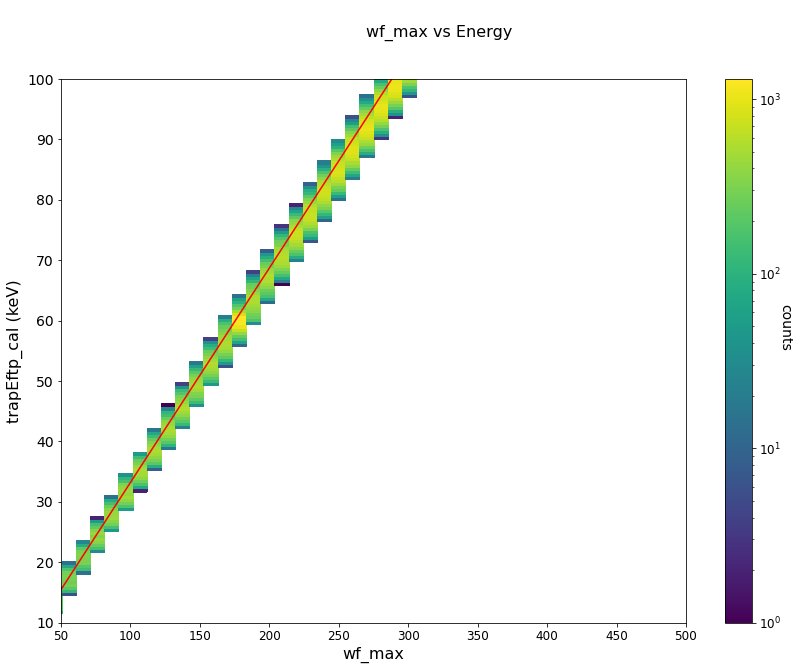

In [103]:
fig, ax = plt.subplots()
elo, ehi, epb = 10, 100, 0.5
e_bins = int((ehi-elo)/epb)
wflo, wfhi = 10, 500
wf_bins = int((wfhi - wflo )/10)
fig.suptitle(f'\nwf_max vs Energy', horizontalalignment='center', fontsize=16)
tp0Vtpmax_hist_norm, xedges, yedges = np.histogram2d(df['wf_max'], df['trapEftp_cal'], bins=[wf_bins, e_bins], range=([wflo, wfhi], [elo, ehi]))
X, Y = np.mgrid[wflo:wfhi:wf_bins*1j, elo:ehi:e_bins*1j]

pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('wf_max', fontsize=16)
ax.set_ylabel('trapEftp_cal (keV)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(200, 1000)
# plt.ylim(0, 400)
y = const*en_bin_centers + offset
plt.plot(en_bin_centers, y, 'r')

# plt.ylim(2000, 5000)
plt.ylim(10, 100)
plt.xlim(50, 500)
plt.show()

In [97]:
df_60 = df.query('trapEftp_cal > 50 and trapEftp_cal < 70') #trapEftp_cal > 50 and trapEftp_cal < 70
total_60 = len(df_60)

df_raw_60 = df_raw.query('trapEftp_cal > 50 and trapEftp_cal < 70')
total_raw_60 = len(df_raw_60)

print(f'{(total_60/total_raw_60)*100}% surviving cut')

81.70458186478693% surviving cut


Look at 60 keV after cuts

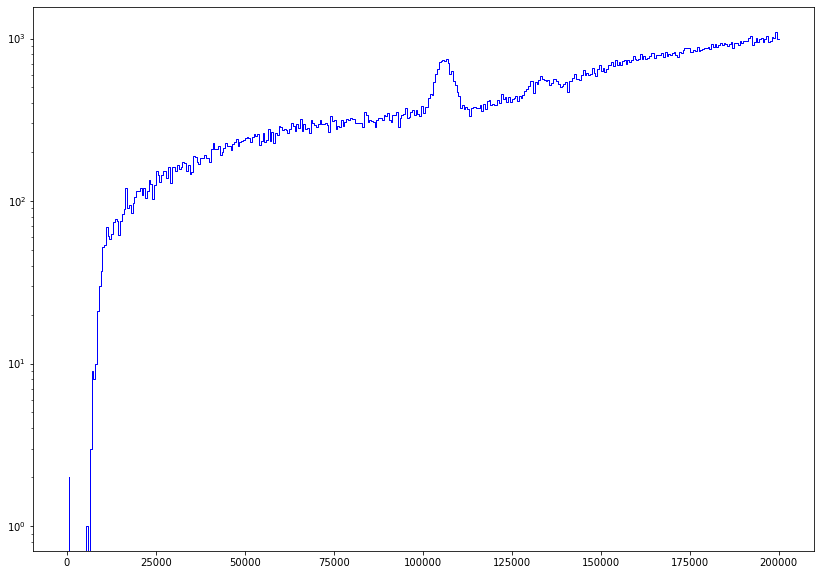

In [98]:
# Make energy spectrum
elo, ehi, epb = 0, 200000, 500
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)

energy_hist, ebins = np.histogram(df['energy'], bins=nbx,
                range=[elo, ehi])


plt.semilogy(ebins[1:], energy_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'

# plt.xlabel(etype, ha='right', x=1)
# plt.ylabel('cts / sec', ha='right', y=1)
# # plt.legend()
# # plt.title(f'{etype}: {runtype} run {run} , {rt_min:.2f} mins')
# plt.savefig(f'./plots/normScan/{runtype}_energy_run{run}.pdf', dpi=200)
# plt.xlim(80000, 150000)
plt.show()

mode: 59.90385839087616
width: 1.6848831280989136
amp: 699.0268413759113


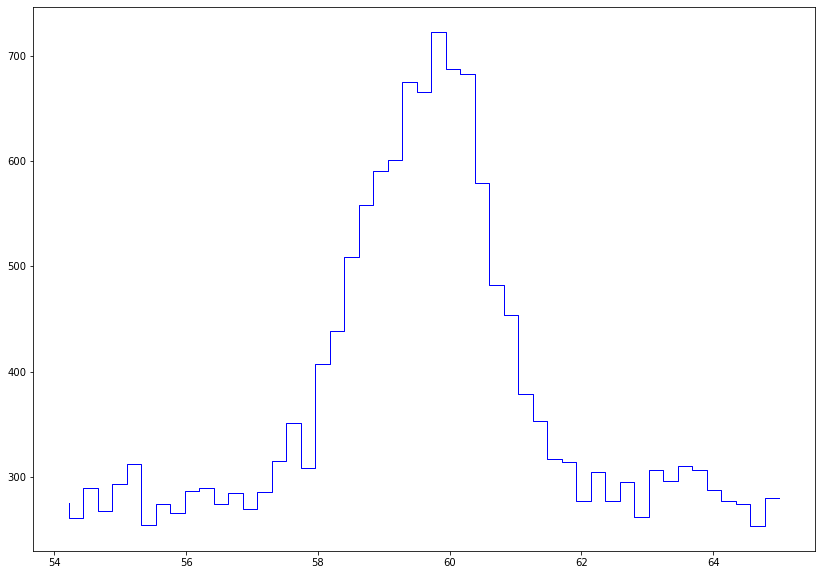

In [101]:
pgfenergy_hist, pgfebins, evars = pgh.get_hist(df_60['trapEftp_cal'], bins=50, range=[54, 65])
plt.plot(pgfebins[1:], pgfenergy_hist, ds='steps', c='b', lw=1)
pars, cov = pgf.gauss_mode_width_max(pgfenergy_hist, pgfebins, evars)
mode = pars[0]
width = pars[1]
amp = pars[2]
print(f'mode: {mode}')
print(f'width: {width}')
print(f'amp: {amp}')

In [102]:
e_pars, ecov = pgf.fit_hist(gauss_fit_func, pgfenergy_hist, pgfebins, evars, guess = (amp, mode, width, 1))

mean_fit = e_pars[1]
width_fit = e_pars[2]
amp_fit = e_pars[0]
const_fit = e_pars[3]

fwhm = width_fit*2.355

print(f'mean: {mean_fit}')
print(f'width: {width_fit}')
print(f'amp: {amp_fit}')
print(f'C: {const_fit}')


print(f'FWHM at 60 keV: {fwhm} \n{(fwhm/mean_fit)*100}%')

mean: 59.65463882225035
width: 0.9398589367644348
amp: 1001.0795949146998
C: 0.6573589673198043
FWHM at 60 keV: 2.213367796080244 
3.7103029031410184%


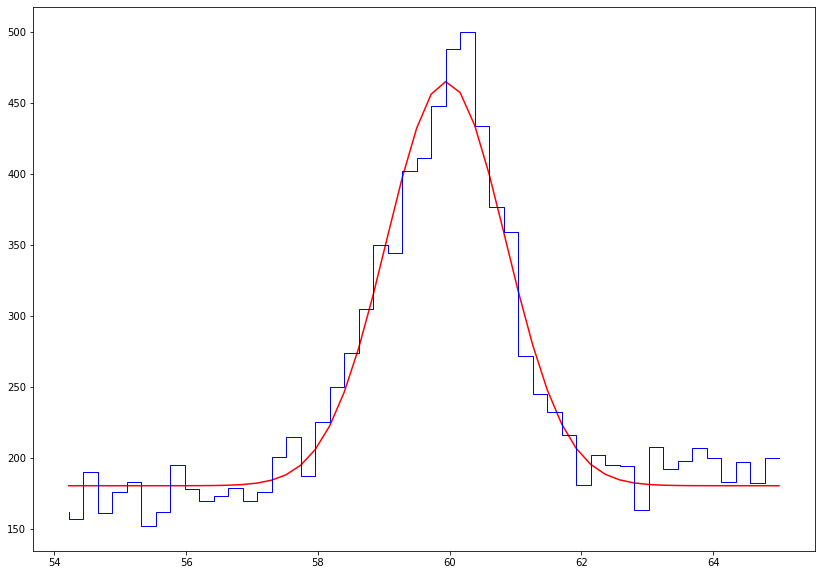

In [68]:
plt.plot(pgfebins[1:], gauss_fit_func(pgfebins[1:], *e_pars), c = 'r')
plt.plot(pgfebins[1:], pgfenergy_hist, ds='steps', c='b', lw=1)

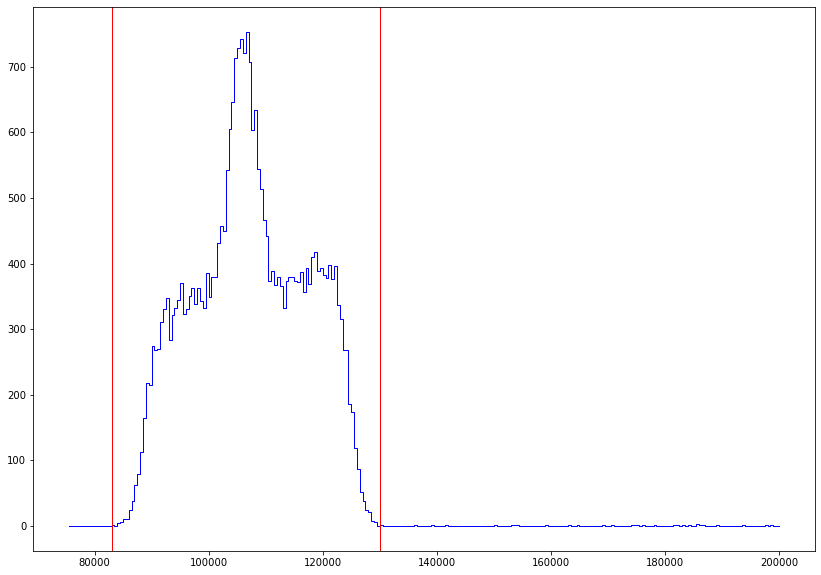

In [114]:
# Make energy spectrum
elo, ehi, epb = 75000, 200000, 500
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10

rawE_lo, rawE_hi = 83000, 130000
        

nbx = int((ehi-elo)/epb)

energy_hist, ebins = np.histogram(df_60['energy'], bins=nbx,
                range=[elo, ehi])

# plt.semilogy(ebins[1:], energy_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'
plt.plot(ebins[1:], energy_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'


plt.axvline(rawE_lo, c='r', lw=1)
plt.axvline(rawE_hi, c='r', lw=1)

# plt.xlabel(etype, ha='right', x=1)
# plt.ylabel('cts / sec', ha='right', y=1)
# # plt.legend()
# # plt.title(f'{etype}: {runtype} run {run} , {rt_min:.2f} mins')
# plt.savefig(f'./plots/normScan/{runtype}_energy_run{run}.pdf', dpi=200)
# plt.xlim(80000, 150000) 
plt.show()

In [115]:
rawE_cut_inverse1 = f'energy< {rawE_lo} ' 
rawE_cut_inverse2 = f'energy > {rawE_hi}'
rawE_cut = f'energy > {rawE_lo} and energy < {rawE_hi}'
low_fail = len(df_60.query(rawE_cut_inverse1).copy())
high_fail = len(df_60.query(rawE_cut_inverse2).copy())
print(f'{low_fail + high_fail} fail cut')
print(f'{len(df_60.query(rawE_cut).copy())} pass cut')
print(f'{len(df_60)} total events')

224 fail cut
30376 pass cut
30600 total events


In [121]:
times, wfs_lowEfail = cage_utils.get_wfs(df_60, dg, rawE_cut_inverse1 , nwfs = 100)

using first 100 waveforms passing cut


ValueError: zero-size array to reduction operation minimum which has no identity

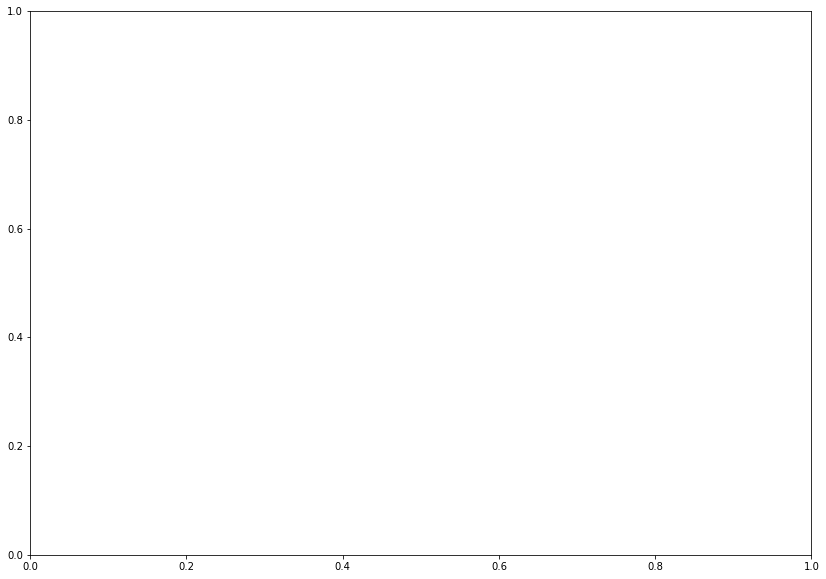

In [122]:


fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_lowEfail)))
c = np.arange(0, len(wfs_lowEfail))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_lowEfail)):
    plt.plot(times, wfs_lowEfail[n][:len(wfs_lowEfail[n])-1], c=cmap.to_rgba(n))

cb = fig.colorbar(cmap)
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{rawE_cut_inverse1}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(3900, 4100)
# plt.xlim(3600, 5000)
# plt.ylim(0,500)

In [123]:
times, wfs_highEfail = cage_utils.get_wfs(df_60, dg, rawE_cut_inverse2 , nwfs = 100)

using first 100 waveforms passing cut


Text(0.5, 0, 'clock cycles')

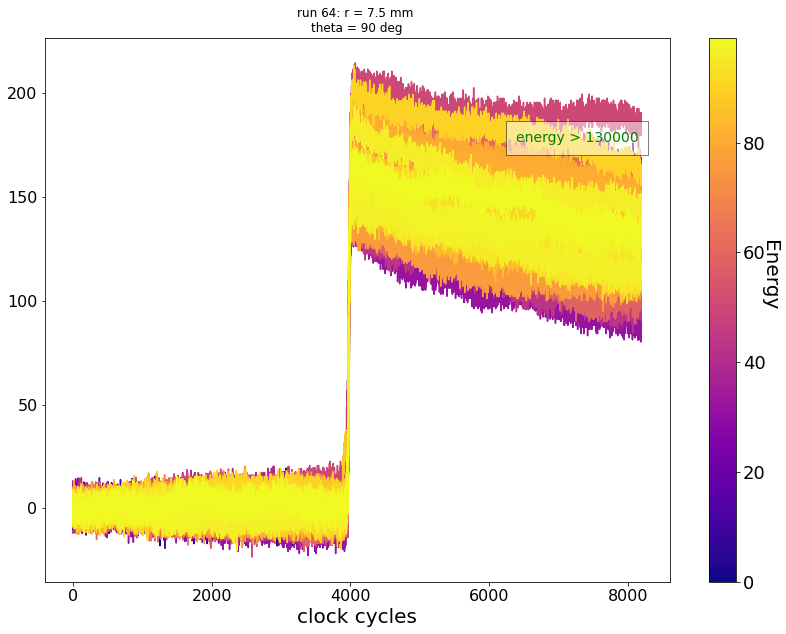

In [124]:


fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_highEfail)))
c = np.arange(0, len(wfs_highEfail))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_highEfail)):
    plt.plot(times, wfs_highEfail[n][:len(wfs_highEfail[n])-1], c=cmap.to_rgba(n))

cb = fig.colorbar(cmap)
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{rawE_cut_inverse2}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(3900, 4100)
# plt.xlim(3600, 5000)
# plt.ylim(0,500)

Baseline cuts

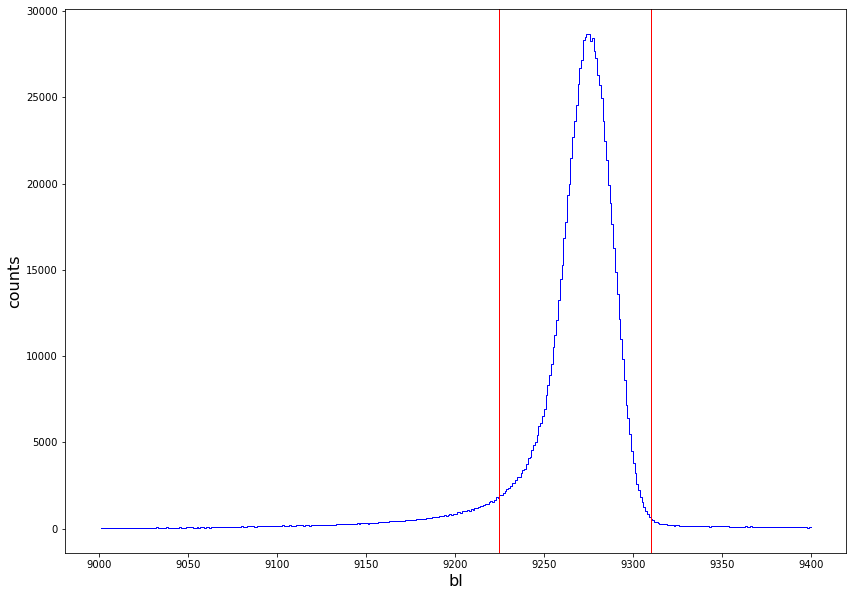

In [126]:
blo, bhi, bpb = 9000,9400, 1
nbx = int((bhi-blo)/bpb)

# bl_cut_lo, bl_cut_hi = 9160,9295 # run 70
bl_cut_lo, bl_cut_hi = 9225,9310

bl_hist, bins = np.histogram(df_raw['bl'], bins=nbx,
                range=[blo, bhi])

plt.plot(bins[1:], bl_hist, ds='steps', c='b', lw=1)


plt.axvline(bl_cut_lo, c='r', lw=1)
plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('bl', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

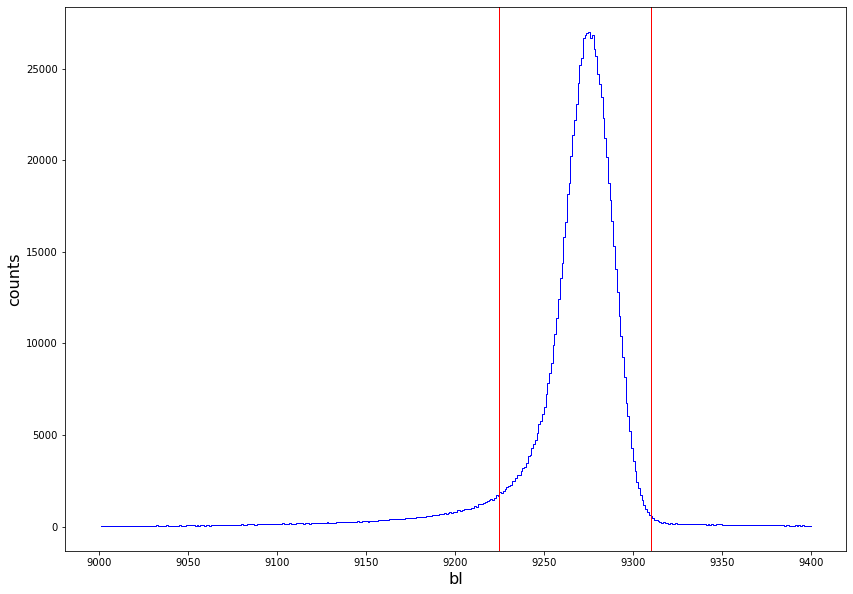

In [127]:
blo, bhi, bpb = 9000,9400, 1
nbx = int((bhi-blo)/bpb)

# bl_cut_lo, bl_cut_hi = 9160,9295 # run 70
bl_cut_lo, bl_cut_hi = 9225,9310

bl_hist, bins = np.histogram(df['bl'], bins=nbx,
                range=[blo, bhi])

plt.plot(bins[1:], bl_hist, ds='steps', c='b', lw=1)


plt.axvline(bl_cut_lo, c='r', lw=1)
plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('bl', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

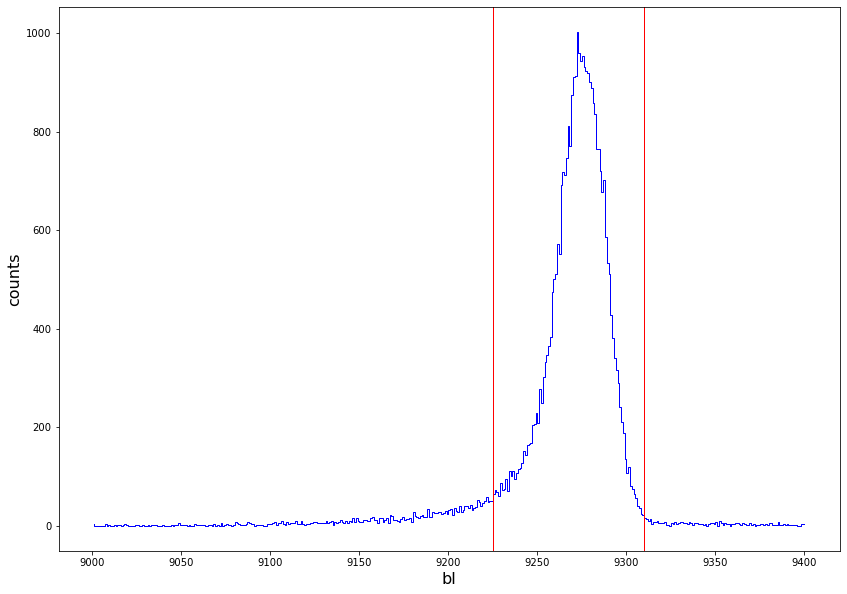

In [128]:
blo, bhi, bpb = 9000,9400, 1
nbx = int((bhi-blo)/bpb)

# bl_cut_lo, bl_cut_hi = 9160,9295 # run 70
bl_cut_lo, bl_cut_hi = 9225,9310

bl_hist, bins = np.histogram(df_raw_60['bl'], bins=nbx,
                range=[blo, bhi])

plt.plot(bins[1:], bl_hist, ds='steps', c='b', lw=1)


plt.axvline(bl_cut_lo, c='r', lw=1)
plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('bl', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

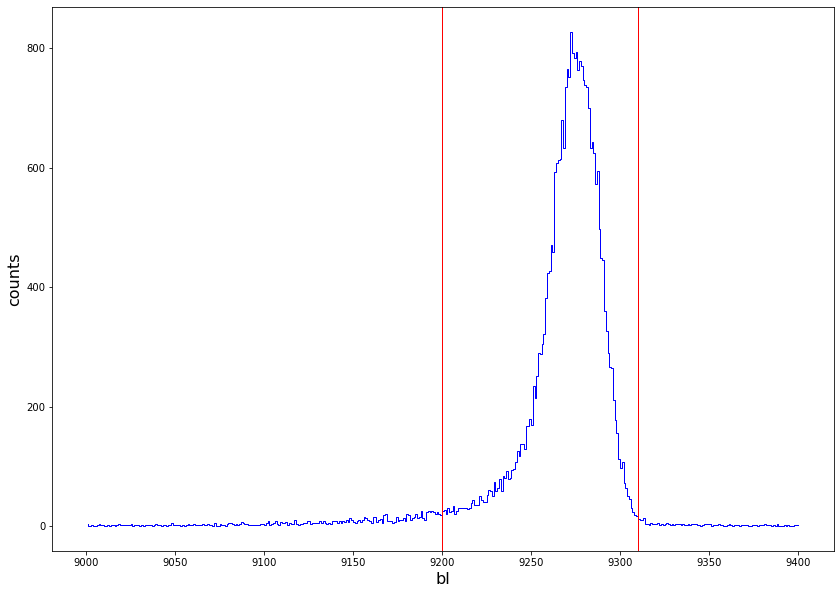

In [139]:
blo, bhi, bpb = 9000,9400, 1
nbx = int((bhi-blo)/bpb)

# bl_cut_lo, bl_cut_hi = 9160,9295 # run 70
bl_cut_lo, bl_cut_hi = 9200,9310

bl_hist, bins = np.histogram(df_60['bl'], bins=nbx,
                range=[blo, bhi])

plt.plot(bins[1:], bl_hist, ds='steps', c='b', lw=1)


plt.axvline(bl_cut_lo, c='r', lw=1)
plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('bl', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

In [140]:
cut_bl_lo = f'bl < {bl_cut_lo}'
cut_bl_hi = f'bl > {bl_cut_hi}'
bl_mean_cut = f'bl > {bl_cut_lo} and bl < {bl_cut_hi}'

fail_bl_lo = len(df_60.query(cut_bl_lo).copy())
fail_bl_hi = len(df_60.query(cut_bl_hi).copy())

print(f'fail bl slope lo cut: {fail_bl_lo} \n{(fail_bl_lo/total_60)*100}%\n')
print(f'fail bl slope hi cut: {fail_bl_hi} \n{(fail_bl_hi/total_60)*100}%')

fail bl slope lo cut: 1362 
4.450980392156863%

fail bl slope hi cut: 208 
0.6797385620915033%


In [141]:
times, wfs_bl_lo = cage_utils.get_wfs(df_60, dg, cut_bl_lo, nwfs = 100)


using first 100 waveforms passing cut


In [134]:
times, wfs_bl_hi = cage_utils.get_wfs(df_60, dg, cut_bl_hi, nwfs = 100)

using first 100 waveforms passing cut


(0.0, 5000.0)

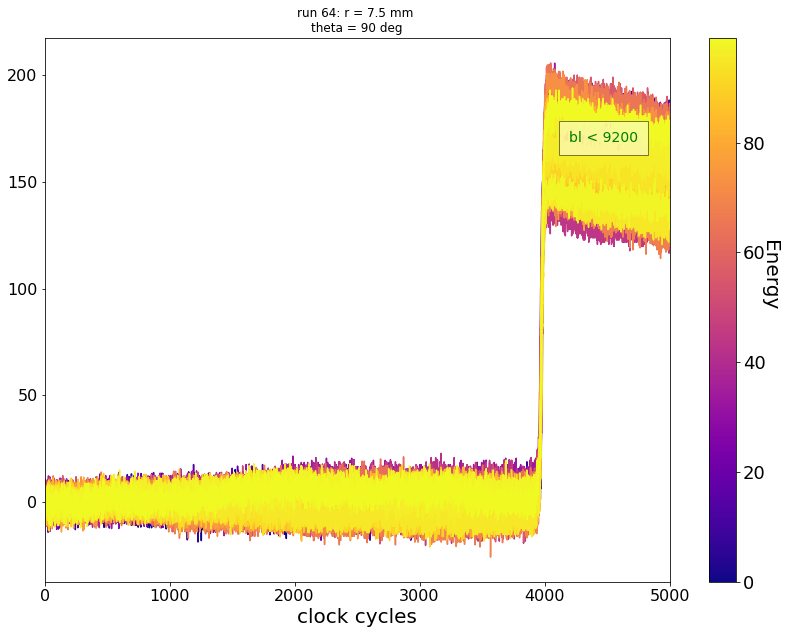

In [142]:


fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_bl_lo)))
c = np.arange(0, len(wfs_bl_lo))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_bl_lo)):
    plt.plot(times, wfs_bl_lo[n][:len(wfs_bl_lo[n])-1], c=cmap.to_rgba(n))

cb = fig.colorbar(cmap)
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_bl_lo}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(3900, 4100)
plt.xlim(0, 5000)
# plt.ylim(0,500)

(0.0, 5000.0)

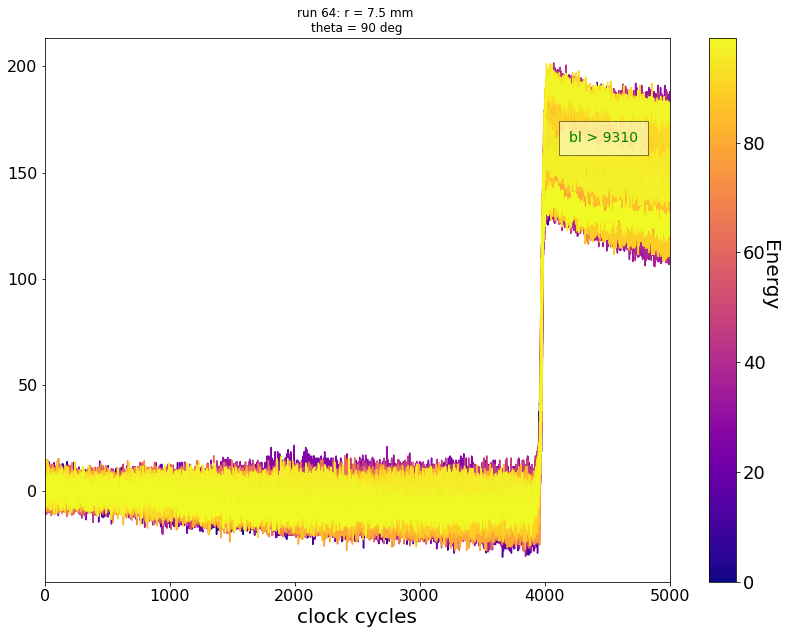

In [135]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_bl_hi)))
c = np.arange(0, len(wfs_bl_hi))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_bl_hi)):
    plt.plot(times, wfs_bl_hi[n][:len(wfs_bl_hi[n])-1], c=cmap.to_rgba(n))

cb = fig.colorbar(cmap)
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_bl_hi}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(3900, 4100)
plt.xlim(0, 5000)
# plt.ylim(0,500)

In [143]:
times, wfs_bl_good = cage_utils.get_wfs(df_60, dg, bl_mean_cut, nwfs = 100)

using first 100 waveforms passing cut


(0.0, 5000.0)

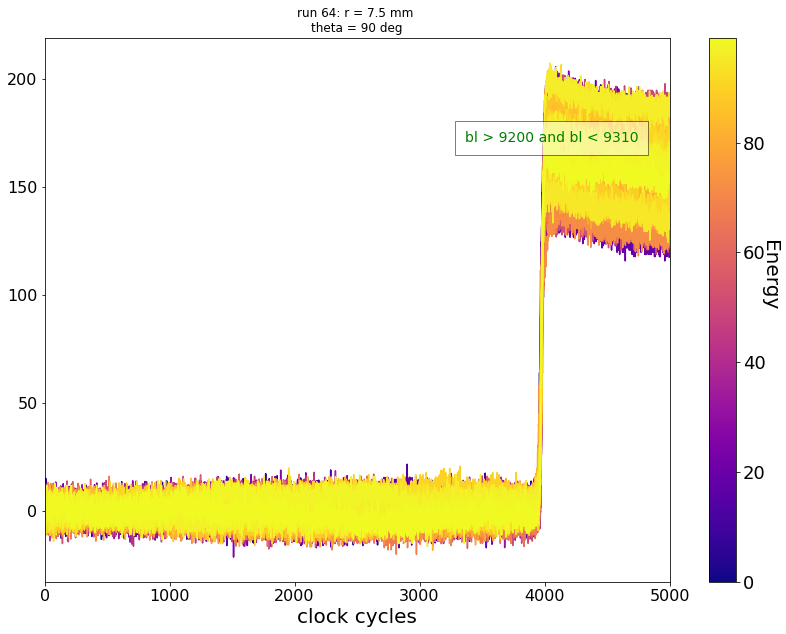

In [144]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_bl_good)))
c = np.arange(0, len(wfs_bl_good))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_bl_good)):
    plt.plot(times, wfs_bl_good[n][:len(wfs_bl_good[n])-1], c=cmap.to_rgba(n))

cb = fig.colorbar(cmap)
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{bl_mean_cut}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(3900, 4100)
plt.xlim(0, 5000)
# plt.ylim(0,500)

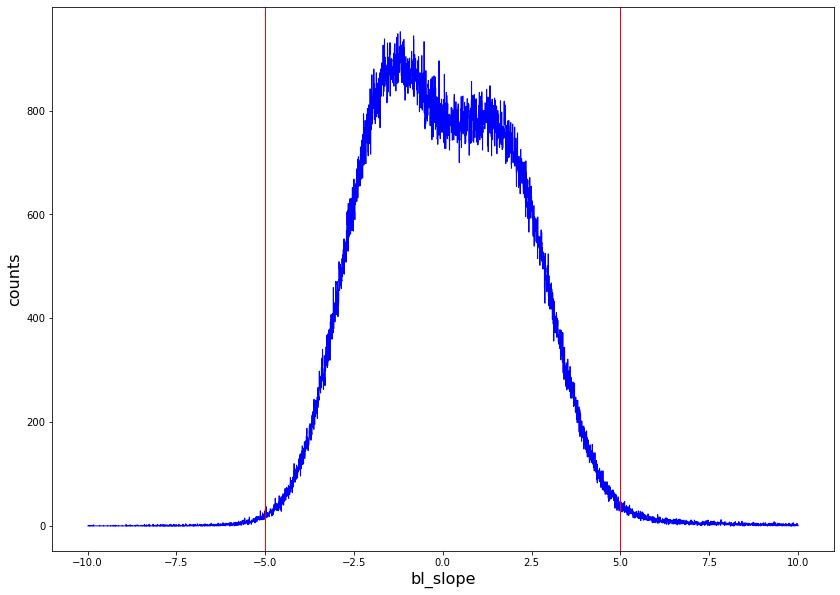

In [145]:
blo, bhi, bpb = -10., 10., 0.005
nbx = int((bhi-blo)/bpb)

# bl_slope_lo, bl_slope_hi = -4.5, 4.5 # run 70
bl_slope_lo, bl_slope_hi = -5.0, 5.

bl_hist, bins = np.histogram(df['bl_slope'], bins=nbx,
                range=[blo, bhi])

plt.plot(bins[1:], bl_hist, ds='steps', c='b', lw=1)


plt.axvline(bl_slope_lo, c='r', lw=1)
plt.axvline(bl_slope_hi, c='r', lw=1)

plt.xlabel('bl_slope', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

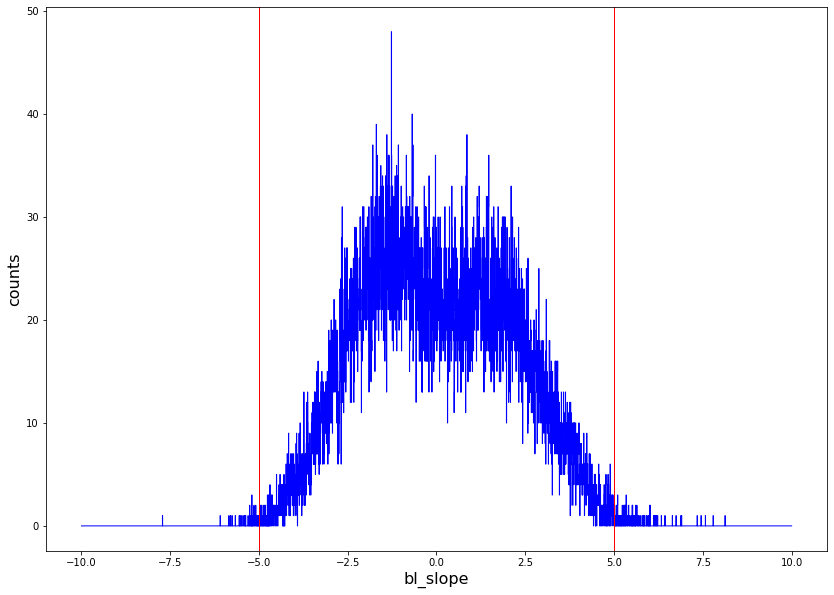

In [146]:
blo, bhi, bpb = -10., 10., 0.005
nbx = int((bhi-blo)/bpb)

# bl_slope_lo, bl_slope_hi = -4.5, 4.5 # run 70
bl_slope_lo, bl_slope_hi = -5., 5.

bl_hist, bins = np.histogram(df_60['bl_slope'], bins=nbx,
                range=[blo, bhi])

plt.plot(bins[1:], bl_hist, ds='steps', c='b', lw=1)


plt.axvline(bl_slope_lo, c='r', lw=1)
plt.axvline(bl_slope_hi, c='r', lw=1)

plt.xlabel('bl_slope', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

In [147]:
cut_bl_slope_lo = f'bl_slope < {bl_slope_lo}'
cut_bl_slope_hi = f'bl_slope > {bl_slope_hi}'
bl_slope_cut = f'bl_slope > {bl_slope_lo} and bl_slope < {bl_slope_hi}'

total_60 = len(df_60)

fail_bl_slope_lo = len(df_60.query(cut_bl_slope_lo).copy())
fail_bl_slope_hi = len(df_60.query(cut_bl_slope_hi).copy())

print(f'fail bl slope lo cut: {fail_bl_slope_lo} \n{(fail_bl_slope_lo/total_60)*100}%')
print(f'fail bl slope hi cut: {fail_bl_slope_hi} \n{(fail_bl_slope_hi/total_60)*100}%')


fail bl slope lo cut: 40 
0.130718954248366%
fail bl slope hi cut: 123 
0.4019607843137255%


In [ ]:
times, wfs_bl_slope_lo = cage_utils.get_wfs(df_raw60, dg, cut_bl_slope_lo, nwfs = 100)


In [ ]:
times, wfs_bl_slope_hi = cage_utils.get_wfs(df_raw60, dg, cut_bl_slope_hi, nwfs = 100)

In [ ]:


fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_bl_slope_lo)))
c = np.arange(0, len(wfs_bl_slope_lo))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_bl_slope_lo)):
    plt.plot(times, wfs_bl_slope_lo[n][:len(wfs_bl_slope_lo[n])-1], c=cmap.to_rgba(n))

cb = fig.colorbar(cmap)
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_bl_slope_lo}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(3900, 4100)
plt.xlim(0, 5000)
# plt.ylim(0,500)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_bl_slope_hi)))
c = np.arange(0, len(wfs_bl_slope_hi))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_bl_slope_hi)):
    plt.plot(times, wfs_bl_slope_hi[n][:len(wfs_bl_slope_hi[n])-1], c=cmap.to_rgba(n))

cb = fig.colorbar(cmap)
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_bl_slope_hi}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(3900, 4100)
plt.xlim(0, 5000)
# plt.ylim(0,500)

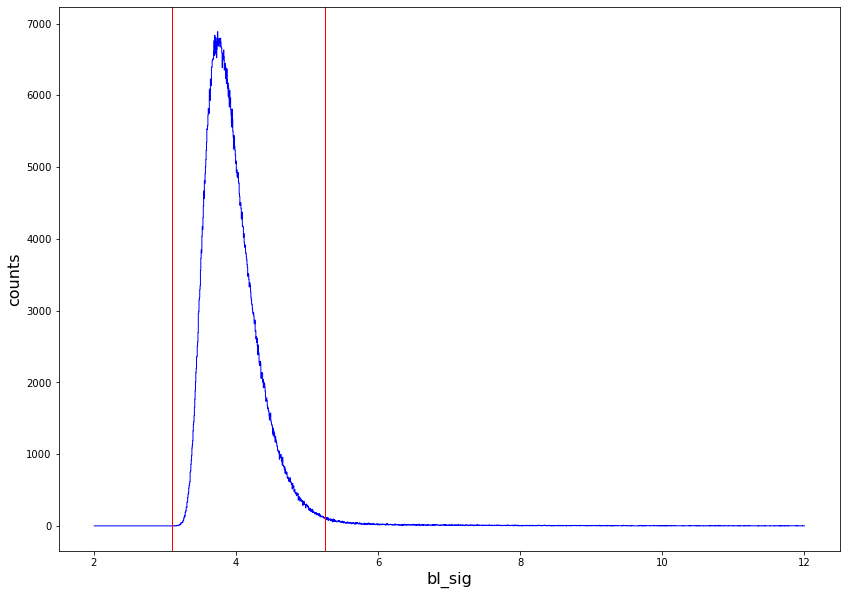

In [148]:
blo, bhi, bpb = 2., 12., 0.005
nbx = int((bhi-blo)/bpb)

# bl_sig_lo, bl_sig_hi = 3.1, 5. # run 70
bl_sig_lo, bl_sig_hi = 3.1, 5.25

bl_hist, bins = np.histogram(df['bl_sig'], bins=nbx,
                range=[blo, bhi])

plt.plot(bins[1:], bl_hist, ds='steps', c='b', lw=1)


plt.axvline(bl_sig_lo, c='r', lw=1)
plt.axvline(bl_sig_hi, c='r', lw=1)

plt.xlabel('bl_sig', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

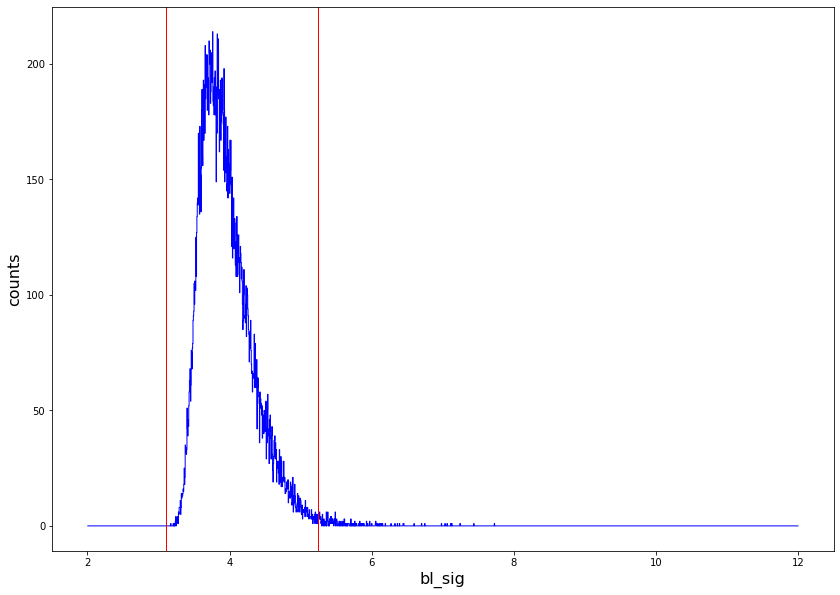

In [149]:
blo, bhi, bpb = 2., 12., 0.005
nbx = int((bhi-blo)/bpb)

# bl_sig_lo, bl_sig_hi = 3.1, 5. # run 70
bl_sig_lo, bl_sig_hi = 3.1, 5.25

bl_hist, bins = np.histogram(df_60['bl_sig'], bins=nbx,
                range=[blo, bhi])

plt.plot(bins[1:], bl_hist, ds='steps', c='b', lw=1)


plt.axvline(bl_sig_lo, c='r', lw=1)
plt.axvline(bl_sig_hi, c='r', lw=1)

plt.xlabel('bl_sig', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

In [150]:

cut_bl_sig_hi = f'bl_sig > {bl_sig_hi}'

bl_sig_cut = f'bl_sig < {bl_sig_hi}'


fail_bl_sig_hi = len(df_60.query(cut_bl_sig_hi).copy())

print(f'fail bl slope hi cut: {fail_bl_sig_hi} \n{(fail_bl_sig_hi/total_60)*100}%')


fail bl slope hi cut: 204 
0.6666666666666667%


In [ ]:
times, wfs_bl_sig_hi = cage_utils.get_wfs(df_60, dg, cut_bl_sig_hi, nwfs = 100)

In [ ]:


fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_bl_sig_hi)))
c = np.arange(0, len(wfs_bl_sig_hi))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_bl_sig_hi)):
    plt.plot(times, wfs_bl_sig_hi[n][:len(wfs_bl_sig_hi[n])-1], c=cmap.to_rgba(n))

cb = fig.colorbar(cmap)
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_bl_sig_hi}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(3900, 4100)
plt.xlim(0, 5000)
# plt.ylim(0,500)

In [151]:
# use baseline cut
# if run <79:
#     bl_cut_lo, bl_cut_hi = 9150,9320
# #     bl_slope_lo, bl_slope_hi = -3., 3.
# if run>79 and run <117:
#     bl_cut_lo, bl_cut_hi = 8500, 10000
# if run>=117:
#     bl_cut_lo, bl_cut_hi = 9700, 9760
# only do basic bl cut before correcting DCR, AoE and ToE.
# If want to add extra cut while correcting AoE or ToE, use cut specifically in their mode_hist() call
# df = df_raw.query(f'bl > {bl_cut_lo} and bl < {bl_cut_hi}').copy()


muon_cut = f'energy < 10000000'
wf_max_cut = f'({const}*wf_max + {offset})*(1-0.04) < trapEftp_cal < ({const}*wf_max + {offset})*(1+0.04)'
bl_mean_cut = f'bl > {bl_cut_lo} and bl < {bl_cut_hi}'
bl_slope_cut = f'bl_slope > {bl_slope_lo} and bl_slope < {bl_slope_hi}'
bl_sig_cut = f'bl_sig < {bl_sig_hi}'

# df = df_raw.query(wf_max_cut).copy() #

# df = df_raw.query(f'bl > {bl_cut_lo} and bl < {bl_cut_hi} and bl_slope > {bl_slope_lo} and bl_slope < {bl_slope_hi} and bl_sig > {bl_sig_lo} and bl_sig < {bl_sig_hi} and wf_max < 15500').copy() #  (trapEftp*(1-0.05) < trapEmax < trapEftp*(1+0.05)) 

Correct DCR, A/E, T/E and create new parameters

In [152]:
if 'dcr' in dsp_list and corr_DCR==True:
    if run>57:
        const, offset, err = cage_utils.corrDCR(df, etype, e_bins=300, elo=0, ehi=6000, dcr_fit_lo=-30, dcr_fit_hi=40)
        df['dcr_plot'] = df['dcr']-offset + ((-1*const))*df[etype]
    elif corr_DCR==True and run<57:
        const = const = 0.0011
        df['dcr_plot'] = df['dcr'] - const*df['trapEftp']
else:
    df['dcr_plot'] = df['dcr']
    
if 'AoE' in dsp_list and corr_AoE==True:
    AoE_mode = cage_utils.mode_hist(df, param='AoE', a_bins=1000, alo=0.005, ahi=0.075, cut=False, cut_str='')
    df['AoE_plot'] = df['AoE'] - AoE_mode
else:
    df['AoE_plot'] = df['AoE']

if 'ToE' in dsp_list and corr_ToE==True:
    ToE_mode = cage_utils.mode_hist(df, param='ToE', a_bins=1000, alo=0.30, ahi=0.45, cut=False, cut_str='')
    df['ToE_plot'] = df['ToE'] - ToE_mode
else:
    df['ToE_plot'] = df['ToE']
    
df['tp0max'] = df['tp_max'] - df['tp_0']
df['tp0max_E'] = df['tp0max']/df['trapEmax']
df['tp0max_wf'] = df['tp0max']/df['wf_max'] 
df['ftp_max'] = df['trapEftp']/df['trapEmax']

Fit results
 slope: 0.004780312765353312
 offset: 0.2952025201791146


In [ ]:
# cut = False

# # Create a cut if appropriate
# eCut_lo, eCut_hi = 50, 1000
# dcr_lo, dcr_hi = 20, 125

# cut_str = f'trapEftp_cal > {eCut_lo} and trapEftp_cal < {eCut_hi}' # and dcr_plot > {dcr_lo} and dcr_plot <{dcr_hi}

# if cut == True:
#     print(f'Using cut: {cut_str}')
#     df_cut = df.query(cut_str).copy()
# else:
#     df_cut = df

Pileup cuts

In [153]:
df_bl = df_raw.query(f'{bl_slope_cut} and {bl_sig_cut} and {wf_max_cut}').copy()
df_sig = df_raw.query(f'{bl_slope_cut} and {bl_mean_cut} and {wf_max_cut}').copy()
df_slope = df_raw.query(f'{bl_mean_cut} and {bl_sig_cut} and {wf_max_cut}').copy()
df_wf_max = df_raw.query(f'{bl_mean_cut} and {bl_sig_cut} and {bl_slope_cut}').copy()


df_bl_60 = df_raw_60.query(f'{bl_slope_cut} and {bl_sig_cut}').copy()
df_sig_60 = df_raw_60.query(f'{bl_slope_cut} and {bl_mean_cut}').copy()
df_slope_60 = df_raw_60.query(f'{bl_mean_cut} and {bl_sig_cut}').copy()
df_wf_max_60 = df_raw_60.query(f'{bl_mean_cut} and {bl_sig_cut} and {bl_slope_cut}').copy()

In [ ]:
# df_bl = df.query(f'{bl_slope_cut} and {bl_sig_cut}').copy()
# df_sig = df.query(f'{bl_slope_cut} and {bl_mean_cut}').copy()
# df_slope = df.query(f'{bl_mean_cut} and {bl_sig_cut}').copy()

# df_bl_60 = df_60.query(f'{bl_slope_cut} and {bl_sig_cut}').copy()
# df_sig_60 = df_60.query(f'{bl_slope_cut} and {bl_mean_cut}').copy()
# df_slope_60 = df_60.query(f'{bl_mean_cut} and {bl_sig_cut}').copy()

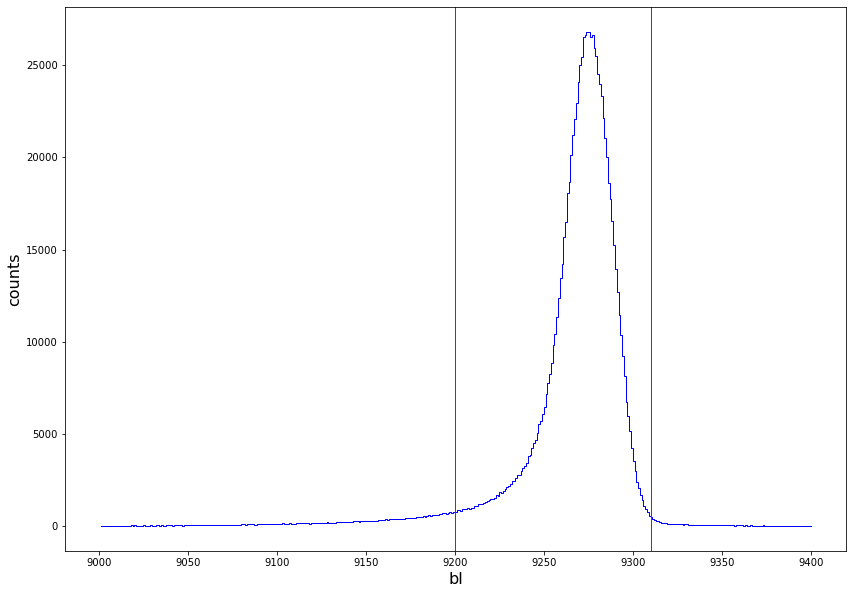

In [154]:
blo, bhi, bpb = 9000,9400, 1
nbx = int((bhi-blo)/bpb)

# bl_cut_lo, bl_cut_hi = 9160,9295 # run 70


bl_hist, bins = np.histogram(df_bl['bl'], bins=nbx,
                range=[blo, bhi])

plt.plot(bins[1:], bl_hist, ds='steps', c='b', lw=1)


plt.axvline(bl_cut_lo, c='r', lw=1)
plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('bl', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

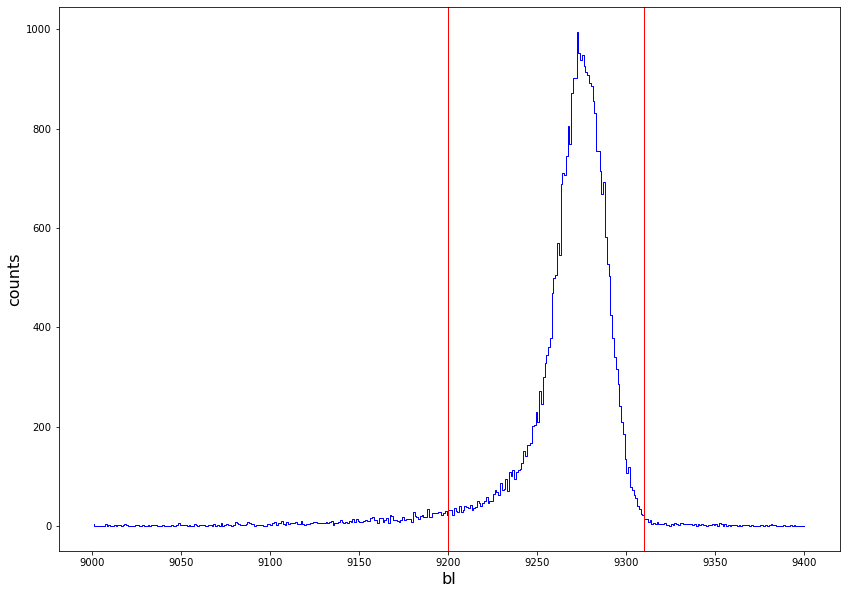

In [155]:
blo, bhi, bpb = 9000,9400, 1
nbx = int((bhi-blo)/bpb)

# bl_cut_lo, bl_cut_hi = 9160,9295 # run 70


bl_hist, bins = np.histogram(df_bl_60['bl'], bins=nbx,
                range=[blo, bhi])

plt.plot(bins[1:], bl_hist, ds='steps', c='b', lw=1)


plt.axvline(bl_cut_lo, c='r', lw=1)
plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('bl', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

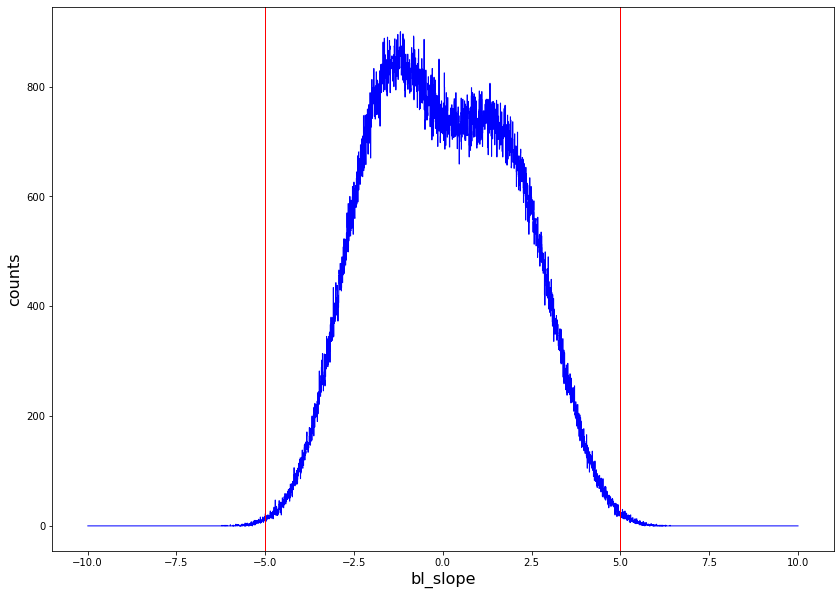

In [156]:
blo, bhi, bpb = -10., 10., 0.005
nbx = int((bhi-blo)/bpb)

# bl_slope_lo, bl_slope_hi = -4.5, 4.5 # run 70


bl_hist, bins = np.histogram(df_slope['bl_slope'], bins=nbx,
                range=[blo, bhi])

plt.plot(bins[1:], bl_hist, ds='steps', c='b', lw=1)


plt.axvline(bl_slope_lo, c='r', lw=1)
plt.axvline(bl_slope_hi, c='r', lw=1)

plt.xlabel('bl_slope', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

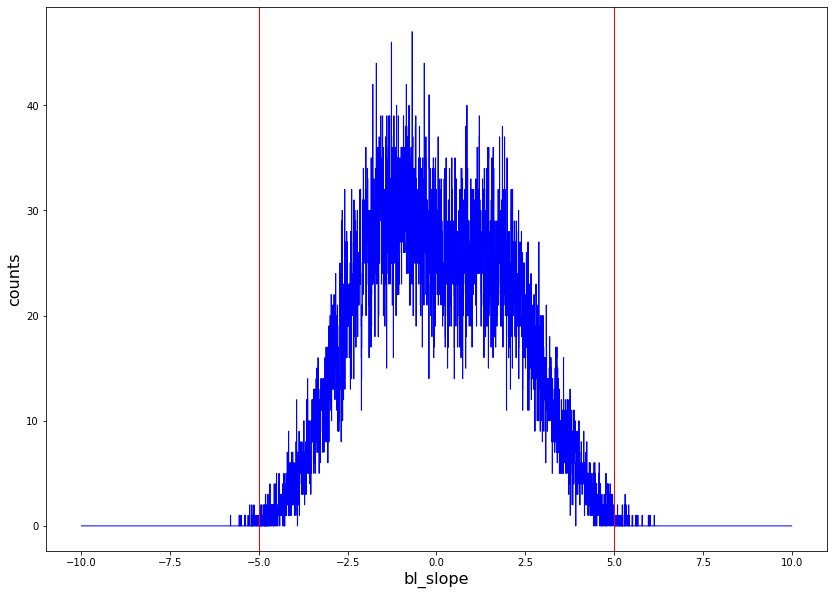

In [157]:
blo, bhi, bpb = -10., 10., 0.005
nbx = int((bhi-blo)/bpb)

# bl_slope_lo, bl_slope_hi = -4.5, 4.5 # run 70


bl_hist, bins = np.histogram(df_slope_60['bl_slope'], bins=nbx,
                range=[blo, bhi])

plt.plot(bins[1:], bl_hist, ds='steps', c='b', lw=1)


plt.axvline(bl_slope_lo, c='r', lw=1)
plt.axvline(bl_slope_hi, c='r', lw=1)

plt.xlabel('bl_slope', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

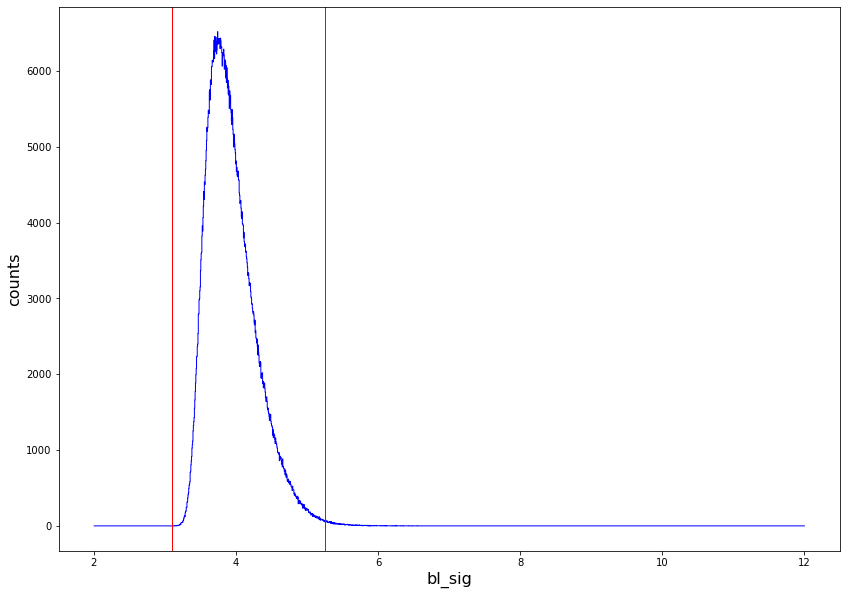

In [158]:
blo, bhi, bpb = 2., 12., 0.005
nbx = int((bhi-blo)/bpb)

# bl_sig_lo, bl_sig_hi = 3.1, 5. # run 70


bl_hist, bins = np.histogram(df_sig['bl_sig'], bins=nbx,
                range=[blo, bhi])

plt.plot(bins[1:], bl_hist, ds='steps', c='b', lw=1)


plt.axvline(bl_sig_lo, c='r', lw=1)
plt.axvline(bl_sig_hi, c='r', lw=1)

plt.xlabel('bl_sig', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

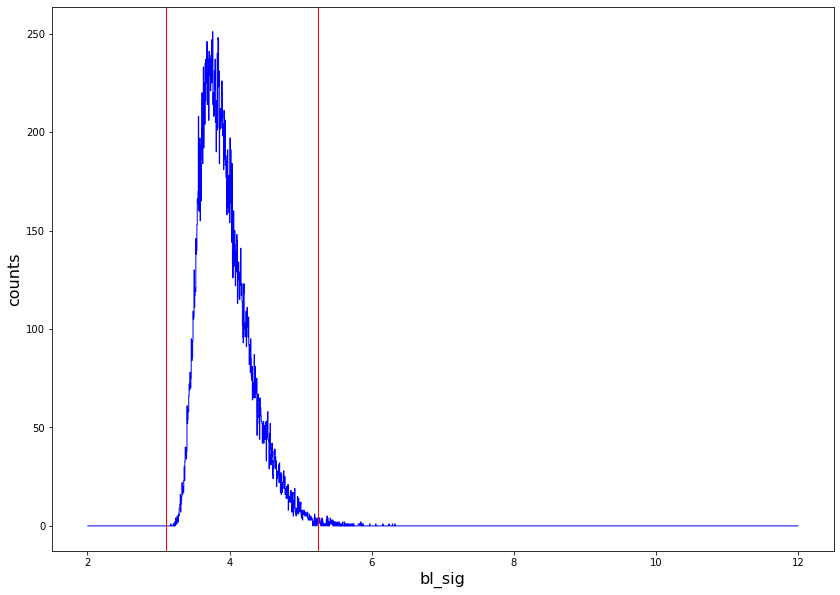

In [159]:
blo, bhi, bpb = 2., 12., 0.005
nbx = int((bhi-blo)/bpb)

# bl_sig_lo, bl_sig_hi = 3.1, 5. # run 70


bl_hist, bins = np.histogram(df_sig_60['bl_sig'], bins=nbx,
                range=[blo, bhi])

plt.plot(bins[1:], bl_hist, ds='steps', c='b', lw=1)


plt.axvline(bl_sig_lo, c='r', lw=1)
plt.axvline(bl_sig_hi, c='r', lw=1)

plt.xlabel('bl_sig', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

<ipython-input-169-b7594be4debc>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())


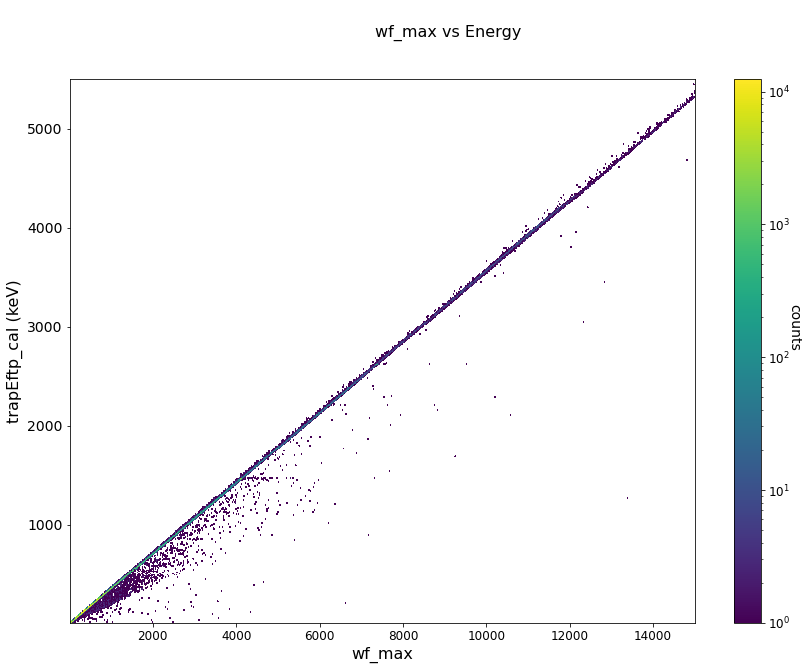

In [169]:
fig, ax = plt.subplots()
elo, ehi, epb = 10, 5500, 10
e_bins = int((ehi-elo)/epb)
wflo, wfhi = 10, 15000
wf_bins = int((wfhi - wflo )/10)
fig.suptitle(f'\nwf_max vs Energy', horizontalalignment='center', fontsize=16)
tp0Vtpmax_hist_norm, xedges, yedges = np.histogram2d(df_wf_max['wf_max'], df_wf_max['trapEftp_cal'], bins=[wf_bins, e_bins], range=([wflo, wfhi], [elo, ehi]))
X, Y = np.mgrid[wflo:wfhi:wf_bins*1j, elo:ehi:e_bins*1j]

pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('wf_max', fontsize=16)
ax.set_ylabel('trapEftp_cal (keV)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(200, 1000)
# plt.ylim(0, 400)
# y = const*en_bin_centers + offset
# plt.plot(en_bin_centers, y, 'r')

# plt.ylim(2000, 5000)
# plt.ylim(10, 100)
# plt.xlim(50, 500)
plt.show()

<ipython-input-184-0c9dbf069211>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())


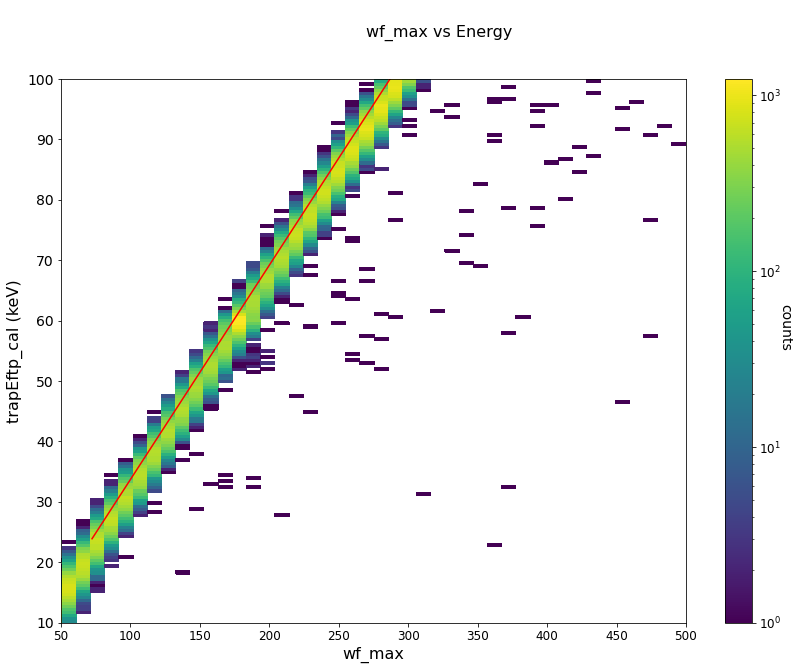

In [184]:
fig, ax = plt.subplots()
elo, ehi, epb = 10, 100, 0.5
e_bins = int((ehi-elo)/epb)
wflo, wfhi = 10, 500
wf_bins = int((wfhi - wflo )/10)
fig.suptitle(f'\nwf_max vs Energy', horizontalalignment='center', fontsize=16)
tp0Vtpmax_hist_norm, xedges, yedges = np.histogram2d(df_wf_max['wf_max'], df_wf_max['trapEftp_cal'], bins=[wf_bins, e_bins], range=([wflo, wfhi], [elo, ehi]))
X, Y = np.mgrid[wflo:wfhi:wf_bins*1j, elo:ehi:e_bins*1j]

pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('wf_max', fontsize=16)
ax.set_ylabel('trapEftp_cal (keV)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(200, 1000)
# plt.ylim(0, 400)
y = const*en_bin_centers + offset
plt.plot(en_bin_centers, y, 'r')

# plt.ylim(2000, 5000)
plt.ylim(10, 100)
plt.xlim(50, 500)
plt.show()

<ipython-input-186-45dd408a93b8>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())


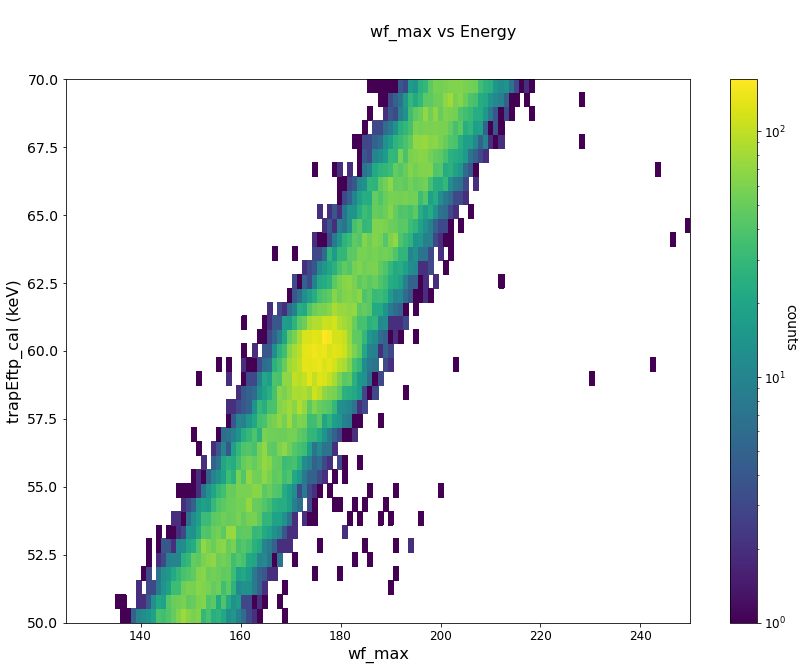

In [186]:
fig, ax = plt.subplots()
elo, ehi, epb = 50, 70, 0.5
e_bins = int((ehi-elo)/epb)
wflo, wfhi = 125, 250
wf_bins = int((wfhi - wflo )/1)
fig.suptitle(f'\nwf_max vs Energy', horizontalalignment='center', fontsize=16)
tp0Vtpmax_hist_norm, xedges, yedges = np.histogram2d(df_wf_max_60['wf_max'], df_wf_max_60['trapEftp_cal'], bins=[wf_bins, e_bins], range=([wflo, wfhi], [elo, ehi]))
X, Y = np.mgrid[wflo:wfhi:wf_bins*1j, elo:ehi:e_bins*1j]

pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('wf_max', fontsize=16)
ax.set_ylabel('trapEftp_cal (keV)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(200, 1000)
# plt.ylim(0, 400)


# plt.ylim(2000, 5000)
# plt.ylim(50, 70)
# plt.xlim(125, 250)
plt.show()

In [ ]:
elo, ehi = 0.925, 1.01
e_bins = int((ehi - elo )/0.001)

ftp_max_lo, ftp_max_hi = 0.98, 1.0

ftp_max_hist, bins = np.histogram(df['ftp_max'], bins=nbx,
                range=[elo, ehi])

plt.plot(bins[1:], ftp_max_hist, ds='steps', c='b', lw=1)


plt.axvline(ftp_max_lo, c='r', lw=1)
plt.axvline(ftp_max_hi, c='r', lw=1)

plt.xlabel('trapEftp/trapEmax', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

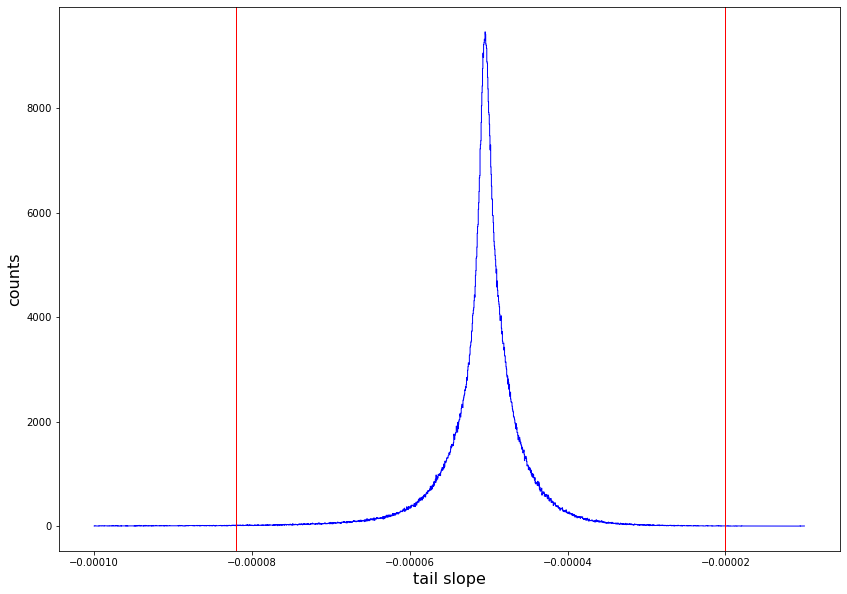

In [203]:
tail_lo, tail_hi = -10e-5, -1e-5 

tail_bins = 100

tail_hist, bins = np.histogram(df['log_tail_fit_slope'], bins=nbx,
                range=[tail_lo, tail_hi])

plt.plot(bins[1:], tail_hist, ds='steps', c='b', lw=1)

tail_slope_lo, tail_slope_hi = -8.2e-5, -2e-5
plt.axvline(tail_slope_lo, c='r', lw=1)
plt.axvline(tail_slope_hi, c='r', lw=1)

plt.xlabel('tail slope', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

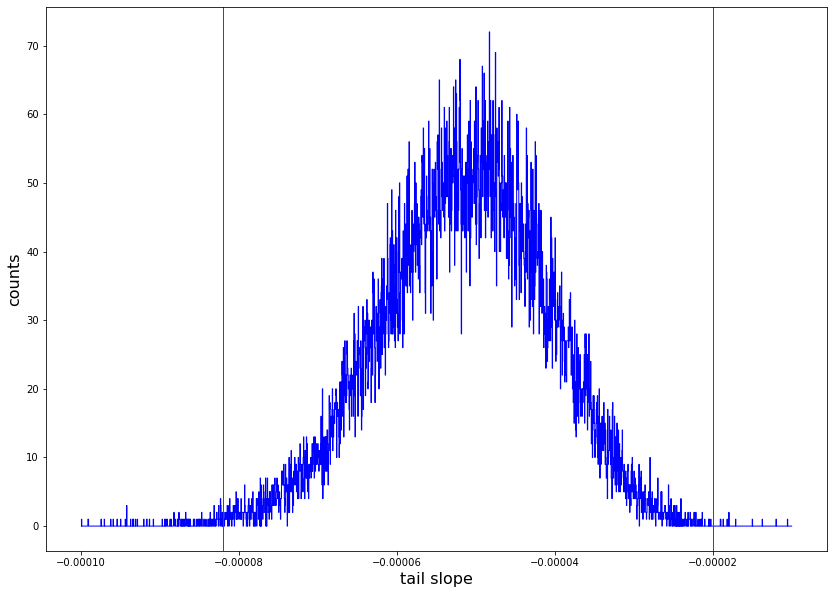

In [202]:
tail_lo, tail_hi = -10e-5, -1e-5 

tail_bins = 100

tail_hist, bins = np.histogram(df_60['log_tail_fit_slope'], bins=nbx,
                range=[tail_lo, tail_hi])

plt.plot(bins[1:], tail_hist, ds='steps', c='b', lw=1)

tail_slope_lo, tail_slope_hi = -8.2e-5, -2e-5
plt.axvline(tail_slope_lo, c='r', lw=1)
plt.axvline(tail_slope_hi, c='r', lw=1)

plt.xlabel('tail slope', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

In [204]:
cut_tail_slope= f'(log_tail_fit_slope < {tail_slope_lo} or log_tail_fit_slope > {tail_slope_hi} ) and trapEftp_cal >55 and trapEftp_cal <62 and ToE_plot > -0.02 and ToE_plot < 0.08' #and trapEftp_cal >1450 and trapEftp_cal <1470 0.9947
# cut_tail_slope= f'log_tail_fit_slope > {tail_slope_lo} and log_tail_fit_slope < {tail_slope_hi} and trapEftp_cal >1450 and trapEftp_cal <1470'

print(f'{len(df_60.query(cut_tail_slope).copy())} events passing cut')
print(len(df_60['trapEftp_cal']))

# times, wfs_tail_slope = cage_utils.get_wfs(df_cut, dg, cut_tail_slope , nwfs = 100)

UndefinedVariableError: name 'ToE_plot' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_tail_slope)))
c = np.arange(0, len(wfs_tail_slope))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_tail_slope)):
    plt.plot(times, wfs_tail_slope[n][:len(wfs_tail_slope[n])-1], c=cmap.to_rgba(n))

cb = fig.colorbar(cmap)
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

# ax.text(0.95, 0.83, f'{cut_tail_slope}', verticalalignment='top',
#                         horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
#                         bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(3900, 4100)
# plt.xlim(3600, 5000)
# plt.ylim(0,500)

In [205]:
elo, ehi = 0.925, 1.01
e_bins = int((ehi - elo )/0.001)

ftp_max_lo, ftp_max_hi = 0.96, 1.0

ftp_max_hist, bins = np.histogram(df_60['ftp_max'], bins=nbx,
                range=[elo, ehi])

plt.semilogy(bins[1:], ftp_max_hist, ds='steps', c='b', lw=1)


plt.axvline(ftp_max_lo, c='r', lw=1)
plt.axvline(ftp_max_hi, c='r', lw=1)

plt.xlabel('trapEftp/trapEmax', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

KeyError: 'ftp_max'

In [ ]:
cut_ftp_max= f'ftp_max < 0.96' #and trapEftp_cal >1450 and trapEftp_cal <1470 0.9947

print(f'{len(df_60.query(cut_ftp_max).copy())} events passing cut')

times, wfs_ftp_max = cage_utils.get_wfs(df_60, dg, cut_ftp_max , nwfs = 100)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_ftp_max)))
c = np.arange(0, len(wfs_ftp_max))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_ftp_max)):
    plt.plot(times, wfs_ftp_max[n][:len(wfs_ftp_max[n])-1], c=cmap.to_rgba(n))

cb = fig.colorbar(cmap)
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_ftp_max}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(3900, 4100)
# plt.xlim(3600, 5000)
plt.ylim(0,200)

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = -10., 10., 0.05 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
ToElo, ToEhi, ToEpb= -0.05, 0.08, 0.0025
ToE_bins  = int((ToEhi-ToElo)/ToEpb)
fig.suptitle(f'\nBaseline slope vs T/E', horizontalalignment='center', fontsize=16)
ToE_vs_bl, xedges, yedges = np.histogram2d(df_60['ToE_plot'], df_60['bl_slope'], bins=[ToE_bins, bl_bins], range=([ToElo, ToEhi], [blo, bhi]))
X, Y = np.mgrid[ToElo:ToEhi:ToE_bins*1j, blo:bhi:bl_bins*1j]

pcm = plt.pcolormesh(X, Y, ToE_vs_bl, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('ToE', fontsize=16)
ax.set_ylabel('bl_slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()
# print(ToElo, ToEhi)

In [ ]:


fig, ax = plt.subplots()
blo, bhi, bpb = -10., 10., 0.05 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
tail_lo, tail_hi = -10e-5, -1e-5 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
tail_bins = 100
fig.suptitle(f'\nTail slope vs baseline slope', horizontalalignment='center', fontsize=16)
bl_vs_tail, xedges, yedges = np.histogram2d(df_60['bl_slope'], df_60['log_tail_fit_slope'], bins=[bl_bins, tail_bins], range=([blo, bhi], [tail_lo, tail_hi]))
X, Y = np.mgrid[blo:bhi:bl_bins*1j, tail_lo:tail_hi:tail_bins*1j]

pcm = plt.pcolormesh(X, Y, bl_vs_tail, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('bl_slope', fontsize=16)
ax.set_ylabel('tail slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
fig, ax = plt.subplots()
tail_lo, tail_hi = -10e-5, -1e-5 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
tail_bins = 100
elo, ehi, epb= 50, 80, 0.25
e_bins  = int((ehi-elo)/epb)
fig.suptitle(f'\ntail slope vs energy', horizontalalignment='center', fontsize=16)
energy_vs_tail, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['log_tail_fit_slope'], bins=[e_bins, tail_bins], range=([elo, ehi], [tail_lo, tail_hi]))
X, Y = np.mgrid[elo:ehi:e_bins*1j, tail_lo:tail_hi:tail_bins*1j]

pcm = plt.pcolormesh(X, Y, energy_vs_tail, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('energy', fontsize=16)
ax.set_ylabel('tail slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()
# print(ToElo, ToEhi)

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = -10., 10., 0.5 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
elo, ehi, epb= 50, 80, 0.25
e_bins  = int((ehi-elo)/epb)
fig.suptitle(f'\nBaseline slope vs energy', horizontalalignment='center', fontsize=16)
energy_vs_bl, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['bl_slope'], bins=[e_bins, bl_bins], range=([elo, ehi], [blo, bhi]))
X, Y = np.mgrid[elo:ehi:e_bins*1j, blo:bhi:bl_bins*1j]

pcm = plt.pcolormesh(X, Y, energy_vs_bl, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('energy', fontsize=16)
ax.set_ylabel('bl_slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()
# print(ToElo, ToEhi)

In [ ]:
fig, ax = plt.subplots()
tail_lo, tail_hi = -10e-5, -1e-5 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
tail_bins = 500
ToElo, ToEhi, ToEpb= -0.05, 0.08, 0.0025
ToE_bins  = int((ToEhi-ToElo)/ToEpb)
fig.suptitle(f'\nTail slope vs T/E', horizontalalignment='center', fontsize=16)
ToE_vs_tail, xedges, yedges = np.histogram2d(df_60['ToE_plot'], df_60['log_tail_fit_slope'], bins=[ToE_bins, tail_bins], range=([ToElo, ToEhi], [tail_lo, tail_hi]))
X, Y = np.mgrid[ToElo:ToEhi:ToE_bins*1j, tail_lo:tail_hi:tail_bins*1j]

pcm = plt.pcolormesh(X, Y, ToE_vs_tail, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('ToE', fontsize=16)
ax.set_ylabel('tail slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:

fig, ax = plt.subplots()
tlo, thi, tpb = 500, 4000, 100
t_bins = int((thi-tlo)/tpb)
elo, ehi = 0.925, 1.01
e_bins = int((ehi - elo )/0.001)
fig.suptitle(f' trapEftp/trapEmax vs tp0max', horizontalalignment='center', fontsize=16)
tp0Vtpmax_hist, xedges, yedges = np.histogram2d(df_cut['ftp_max'], df_cut['tp0max'], bins=[e_bins, t_bins], range=([elo, ehi], [tlo, thi]))
X, Y = np.mgrid[elo:ehi:e_bins*1j, tlo:thi:t_bins*1j]

pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('trapEftp/trapEmax', fontsize=16)
ax.set_ylabel('tp0max)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.show()

In [ ]:
print(df_cut['wf_argmax'])

In [ ]:
# Make energy spectrum
wflo, wfhi, wfpb = 40000, 50000, 50
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((wfhi-wflo)/wfpb)

wf_argmax_hist, bins = np.histogram(df_cut['wf_argmax'], bins=nbx,
                range=[wflo, wfhi])

plt.semilogy(bins[1:], wf_argmax_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'

# plt.xlabel(etype, ha='right', x=1)
# plt.ylabel('cts / sec', ha='right', y=1)
# # plt.legend()
# # plt.title(f'{etype}: {runtype} run {run} , {rt_min:.2f} mins')
# plt.savefig(f'./plots/normScan/{runtype}_energy_run{run}.pdf', dpi=200)
# plt.xlim(80000, 150000)
plt.show()

In [ ]:
cut_wf_argmax = f' wf_argmax > 41000'

print(f'{len(df_cut.query(cut_wf_argmax ).copy())} events passing cut')

times, wfs_argmax = cage_utils.get_wfs(df_cut, dg, cut_wf_argmax , nwfs = 100)

In [ ]:
df_cut = df_cut.query(f'(trapEftp*(1-0.05) < trapEmax < trapEftp*(1+0.05))').copy()

In [ ]:
# fig, ax = plt.subplots(figsize=(9,8))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_argmax)))
c = np.arange(0, len(wfs_argmax))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_argmax)):
    plt.plot(times, wfs_argmax[n][:len(wfs_argmax[n])-1], c=cmap.to_rgba(n))

# cb = fig.colorbar(cmap, ticks=(57.5, 59.5))
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_wf_argmax}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
plt.xlim(3800, 4500)
# plt.ylim(3000, 6000)
# plt.ylim(0,500)

In [ ]:
# Make energy spectrum
wflo, wfhi, wfpb = 40000, 50000, 50
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((wfhi-wflo)/wfpb)

wf_argmax_hist, bins = np.histogram(df_cut['trapE_argmax'], bins=nbx,
                range=[wflo, wfhi])

plt.semilogy(bins[1:], wf_argmax_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'

plt.axvline(44900, c='r', lw=1)
plt.axvline(45000, c='r', lw=1)


# plt.xlabel(etype, ha='right', x=1)
# plt.ylabel('cts / sec', ha='right', y=1)
# # plt.legend()
# # plt.title(f'{etype}: {runtype} run {run} , {rt_min:.2f} mins')
# plt.savefig(f'./plots/normScan/{runtype}_energy_run{run}.pdf', dpi=200)
# plt.xlim(80000, 150000)
plt.show()

In [ ]:
fig, ax = plt.subplots()
wflo, wfhi, wfpb = 41000, 45500, 50
wf_bins = int((wfhi-wflo)/wfpb)

elo, ehi, epb= 50, 1500, 10
e_bins  = int((ehi-elo)/epb)
fig.suptitle(f'\ntrapE_argmax vs energy', horizontalalignment='center', fontsize=16)
energy_vs_trapE_argmax, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['trapE_argmax'], bins=[e_bins, wf_bins], range=([elo, ehi], [wflo, wfhi]))
X, Y = np.mgrid[elo:ehi:e_bins*1j, wflo:wfhi:wf_bins*1j]

pcm = plt.pcolormesh(X, Y, energy_vs_trapE_argmax, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('energy', fontsize=16)
ax.set_ylabel('trapE_argmax', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()
# print(ToElo, ToEhi)

In [ ]:
# cut_trapE_argmax = f' trapE_argmax > 44900 and trapE_argmax < 45000' #and trapE_argmax < 44500
cut_trapE_argmax = f' trapE_argmax > 44900 and trapEftp_cal < 500' #and trapEftp_cal > 1000

print(f'{len(df_cut.query(cut_trapE_argmax ).copy())} events passing cut')

times, wfs_trapE_argmax = cage_utils.get_wfs(df_cut, dg, cut_trapE_argmax , nwfs = 100)

In [ ]:
# fig, ax = plt.subplots(figsize=(9,8))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_trapE_argmax)))
c = np.arange(0, len(wfs_trapE_argmax))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_trapE_argmax)):
    plt.plot(times, wfs_trapE_argmax[n][:len(wfs_trapE_argmax[n])-1], c=cmap.to_rgba(n))

# cb = fig.colorbar(cmap, ticks=(57.5, 59.5))
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_trapE_argmax}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(3800, 4200)
# plt.ylim(8000, 12000)
# plt.ylim(0,500)

In [ ]:
# cut_trapE_argmax = f' trapE_argmax > 44900 and trapE_argmax < 45000' #and trapE_argmax < 44500
cut_hi_trapE_argmax = f' trapE_argmax > 42500 and trapEftp_cal > 800' #and trapEftp_cal > 1000

print(f'{len(df_cut.query(cut_hi_trapE_argmax  ).copy())} events passing cut')

# times, wfs_hi_trapE_argmax = cage_utils.get_wfs(df_cut, dg, cut_hi_trapE_argmax , nwfs = 100)

In [ ]:
# fig, ax = plt.subplots(figsize=(9,8))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_hi_trapE_argmax)))
c = np.arange(0, len(wfs_hi_trapE_argmax))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_hi_trapE_argmax)):
    plt.plot(times, wfs_hi_trapE_argmax[n][:len(wfs_hi_trapE_argmax[n])-1], c=cmap.to_rgba(n))

# cb = fig.colorbar(cmap, ticks=(57.5, 59.5))
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_trapE_argmax}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(3800, 4200)
# plt.ylim(8000, 12000)
# plt.ylim(0,500)

In [ ]:
cut_1460 = f' trapEftp_cal >1450 and trapEftp_cal < 1470'

print(f'{len(df_cut.query(cut_1460).copy())} events passing cut')

times, wfs_1460 = cage_utils.get_wfs(df_cut, dg, cut_1460, nwfs = 100)

In [ ]:
# fig, ax = plt.subplots(figsize=(9,8))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_1460)))
c = np.arange(0, len(wfs_1460))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_1460)):
    plt.plot(times, wfs_1460[n][:len(wfs_1460[n])-1], c=cmap.to_rgba(n))

# cb = fig.colorbar(cmap, ticks=(57.5, 59.5))
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'1460 keV', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
plt.xlim(3800, 4200)
# plt.ylim(3000, 6000)
# plt.ylim(0,500)

In [ ]:
cut_1 = f' tp0max> 500 and tp0max <2000 and ftp_max >0.94 and ftp_max <0.97 '

print(f'{len(df_cut.query(cut_1).copy())} events passing cut')

In [ ]:
times, wfs_1 = cage_utils.get_wfs(df_cut, dg, cut_1, nwfs = 100)

In [ ]:
# fig, ax = plt.subplots(figsize=(9,8))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_1)))
c = np.arange(0, len(wfs_1))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_1)):
    plt.plot(times, wfs_1[n][:len(wfs_1[n])-1], c=cmap.to_rgba(n))

# cb = fig.colorbar(cmap, ticks=(57.5, 59.5))
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_1}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(4000, 8000)
# plt.ylim(3000, 6000)
# plt.ylim(0,500)

In [ ]:
cut_2 = f' tp0max > 2000 and tp0max < 4000 and ftp_max >0.94 and ftp_max <0.97 and trapEftp_cal >100'

print(f'{len(df_cut.query(cut_2).copy())} events passing cut')

In [ ]:
times, wfs_2 = cage_utils.get_wfs(df_cut, dg, cut_2, nwfs = 100)

In [ ]:
# fig, ax = plt.subplots(figsize=(9,8))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_2)))
c = np.arange(0, len(wfs_2))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_2)):
    plt.plot(times, wfs_2[n][:len(wfs_2[n])-1], c=cmap.to_rgba(n))

# cb = fig.colorbar(cmap, ticks=(57.5, 59.5))
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_2}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
plt.xlim(3500, 4500)
# plt.ylim(3000, 6000)
# plt.ylim(0,500)

In [ ]:
cut_3 = f' tp0max > 2500 and tp0max < 4000 and trapEftp_cal >100'

print(f'{len(df_cut.query(cut_3).copy())} events passing cut')

In [ ]:
times, wfs_3 = cage_utils.get_wfs(df_cut, dg, cut_3, nwfs = 100)

In [ ]:
# fig, ax = plt.subplots(figsize=(9,8))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_3)))
c = np.arange(0, len(wfs_3))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_3)):
    plt.plot(times, wfs_3[n][:len(wfs_3[n])-1], c=cmap.to_rgba(n))

# cb = fig.colorbar(cmap, ticks=(57.5, 59.5))
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_3}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
plt.xlim(3800, 4200)
# plt.ylim(3000, 6000)
plt.ylim(0,1000)

In [ ]:
fig, ax = plt.subplots()
tlo, thi, tpb = 500, 4000, 100
t_bins = int((thi-tlo)/tpb)
ToElo, ToEhi, ToEpb= -0.2, 0.2, 0.0025
ToE_bins  = int((ToEhi-ToElo)/ToEpb)
fig.suptitle(f'tp0max_E vs Energy', horizontalalignment='center', fontsize=16)
ToE_vs_tp0max, xedges, yedges = np.histogram2d(df_cut['ToE_plot'], df_cut['tp0max'], bins=[ToE_bins, t_bins], range=([ToElo, ToEhi], [tlo, thi]))
X, Y = np.mgrid[ToElo:ToEhi:ToE_bins*1j, tlo:thi:t_bins*1j]

pcm = plt.pcolormesh(X, Y, ToE_vs_tp0max, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('tp0max)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()
print(ToElo, ToEhi)

In [ ]:
fig, ax = plt.subplots()
elo, ehi, epb = 40, 80, 0.5
ToElo, ToEhi, ToEpb= -0.2, 0.2, 0.0025

nbx = int((ehi-elo)/epb)
nby = int((ToEhi-ToElo)/ToEpb)



fig.suptitle(f'T/E vs Energy', horizontalalignment='center', fontsize=16)

ToE_hist_norm, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['ToE_plot'], bins=[nbx, nby], range=([elo, ehi], [ToElo, ToEhi]))
X, Y = np.mgrid[elo:ehi:nbx*1j, ToElo:ToEhi:nby*1j]


pcm = plt.pcolormesh(X, Y, ToE_hist_norm, norm=LogNorm()) #0.002, 0.2

cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel(f'Energy (keV)', fontsize=16)
ax.set_ylabel('T/E (arb)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)


ax.text(0.95, 0.83, f'r = {radius} mm \ntheta = {angle_det} deg \nwf_triangle 100 ns, 10 ns', verticalalignment='bottom',
            horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

# plt.legend()
plt.title(f'\n{runtype} run {run}, {rt_min:.2f} mins', fontsize=12)
plt.tight_layout()
# plt.ylim(-0.05, 0.1)
# plt.ylim(-0.05, 0.08)
plt.ylim(-0.2, 0.2)
# plt.xlim(52.5, 65)
plt.show()

In [ ]:
cut_4 = f' ToE_plot < -0.05 and tp0max > 2500 and tp0max < 4000 and trapEftp_cal > 55 and trapEftp_cal < 62'

print(f'{len(df_cut.query(cut_4).copy())} events passing cut')

In [ ]:
times, wfs_4 = cage_utils.get_wfs(df_cut, dg, cut_4, nwfs = 100)

In [ ]:
# fig, ax = plt.subplots(figsize=(9,8))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_4)))
c = np.arange(0, len(wfs_4))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_4)):
    plt.plot(times, wfs_4[n][:len(wfs_4[n])-1], c=cmap.to_rgba(n))

# cb = fig.colorbar(cmap, ticks=(57.5, 59.5))
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_4}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(3900, 4400)
# plt.ylim(100, 300)
# plt.ylim(0,1000)

In [ ]:
cut_5 = f' ToE_plot > -0.05 and ToE_plot <  0.05 and trapEftp_cal > 55 and trapEftp_cal < 62'

print(f'{len(df_cut.query(cut_5).copy())} events passing cut')

In [ ]:
times, wfs_5 = cage_utils.get_wfs(df_cut, dg, cut_5, nwfs = 100)

In [ ]:
# fig, ax = plt.subplots(figsize=(9,8))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_5)))
c = np.arange(0, len(wfs_5))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_5)):
    plt.plot(times, wfs_5[n][:len(wfs_5[n])-1], c=cmap.to_rgba(n))

# cb = fig.colorbar(cmap, ticks=(57.5, 59.5))
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_5}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
plt.xlim(3900, 4400)
# plt.ylim(3000, 6000)
# plt.ylim(0,200)

In [ ]:
fig, ax = plt.subplots()
tlo, thi, tpb = 500, 4000, 100
t_bins = int((thi-tlo)/tpb)
wflo, wfhi = 50, 18000
wf_bins = int((wfhi - wflo )/10)
fig.suptitle(f'tp0max_E vs Energy', horizontalalignment='center', fontsize=16)
tp0Vtpmax_hist_norm, xedges, yedges = np.histogram2d(df_cut['wf_max'], df_cut['tp0max'], bins=[wf_bins, t_bins], range=([wflo, wfhi], [tlo, thi]))
X, Y = np.mgrid[wflo:wfhi:wf_bins*1j, tlo:thi:t_bins*1j]

pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('energy (keV)', fontsize=16)
ax.set_ylabel('tp0max_E (arb)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.show()

In [ ]:
tp_cut = f'tp0max > 2000'
print(f'{len(df_cut.query(tp_cut).copy())} events passing cut')

In [ ]:
times, wfs_tp_cut = cage_utils.get_wfs(df_cut, dg, tp_cut, nwfs = 100)

In [ ]:
# fig, ax = plt.subplots(figsize=(9,8))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_tp_cut)))
c = np.arange(0, len(wfs_tp_cut))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_tp_cut)):
    plt.plot(times, wfs_tp_cut[n][:len(wfs_tp_cut[n])-1], c=cmap.to_rgba(n))

# cb = fig.colorbar(cmap, ticks=(57.5, 59.5))
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{tp_cut}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(3900, 4400)
# plt.ylim(3000, 6000)
plt.ylim(0,2000)

In [ ]:
fig, ax = plt.subplots()
tlo, thi, tpb = 0, 25, 1
t_bins = int((thi-tlo)/tpb)
wflo, wfhi = 50, 8000
wf_bins = int((wfhi - wflo )/10)
fig.suptitle(f'\ntp0max/wf_max vs wf_max', horizontalalignment='center', fontsize=16)
tp0Vtpmax_hist_norm, xedges, yedges = np.histogram2d(df_cut['wf_max'], df_cut['tp0max_wf'], bins=[wf_bins, t_bins], range=([wflo, wfhi], [tlo, thi]))
X, Y = np.mgrid[wflo:wfhi:wf_bins*1j, tlo:thi:t_bins*1j]

pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('wf_max', fontsize=16)
ax.set_ylabel('tp0max/wf_max (arb)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.show()

In [ ]:
fig, ax = plt.subplots()
elo, ehi, epb = 50, 5500, 10
e_bins = int((ehi-elo)/epb)
wflo, wfhi = 50, 15500
wf_bins = int((wfhi - wflo )/10)
fig.suptitle(f'\nwf_max vs Energy', horizontalalignment='center', fontsize=16)
tp0Vtpmax_hist_norm, xedges, yedges = np.histogram2d(df_cut['wf_max'], df_cut['trapEftp_cal'], bins=[wf_bins, e_bins], range=([wflo, wfhi], [elo, ehi]))
X, Y = np.mgrid[wflo:wfhi:wf_bins*1j, elo:ehi:e_bins*1j]

pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('wf_max', fontsize=16)
ax.set_ylabel('trapEftp_cal (keV)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(200, 1000)
# plt.ylim(0, 400)
plt.show()

In [ ]:
median, xedges, binnumber = stats.binned_statistic(df_cut['wf_max'], df_cut['trapEftp_cal'], statistic = "median", bins = wf_bins)

en_bin_centers = pgh.get_bin_centers(xedges)

fit_raw, cov = np.polyfit(en_bin_centers, median, deg=1, cov=True)

const = fit_raw[0]
offset = fit_raw[1]
err = np.sqrt(np.diag(cov))

In [ ]:
fig, ax = plt.subplots()
elo, ehi, epb = 50, 5500, 10
e_bins = int((ehi-elo)/epb)
wflo, wfhi = 50, 15500
wf_bins = int((wfhi - wflo )/10)
fig.suptitle(f'\nwf_max vs Energy', horizontalalignment='center', fontsize=16)
tp0Vtpmax_hist_norm, xedges, yedges = np.histogram2d(df_cut['wf_max'], df_cut['trapEftp_cal'], bins=[wf_bins, e_bins], range=([wflo, wfhi], [elo, ehi]))
X, Y = np.mgrid[wflo:wfhi:wf_bins*1j, elo:ehi:e_bins*1j]

pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('wf_max', fontsize=16)
ax.set_ylabel('trapEftp_cal (keV)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(200, 1000)
# plt.ylim(0, 400)
y = const*en_bin_centers + offset
plt.plot(en_bin_centers, y, 'r')
plt.show()

In [ ]:
cut_wf_trapEftp = f'({const}*wf_max + {offset})*(1-0.05) < trapEftp_cal < ({const}*wf_max + {offset})*(1+0.5)'
print(f'{len(df_cut.query(cut_wf_trapEftp).copy())} events passing cut')
df_wf_trapEftp = df_cut.query(cut_wf_trapEftp).copy()

In [ ]:
fig, ax = plt.subplots()
elo, ehi, epb = 50, 5500, 10
e_bins = int((ehi-elo)/epb)
wflo, wfhi = 50, 15500
wf_bins = int((wfhi - wflo )/10)
fig.suptitle(f'\nwf_max vs Energy', horizontalalignment='center', fontsize=16)
tp0Vtpmax_hist_norm, xedges, yedges = np.histogram2d(df_wf_trapEftp['wf_max'], df_wf_trapEftp['trapEftp_cal'], bins=[wf_bins, e_bins], range=([wflo, wfhi], [elo, ehi]))
X, Y = np.mgrid[wflo:wfhi:wf_bins*1j, elo:ehi:e_bins*1j]

pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('wf_max', fontsize=16)
ax.set_ylabel('trapEftp_cal (keV)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.xlim(200, 1000)
plt.ylim(0, 400)
y = const*en_bin_centers + offset
plt.plot(en_bin_centers, y, 'r')
plt.show()

In [ ]:
fig, ax = plt.subplots()
tlo, thi, tpb = 0, 25, 1
t_bins = int((thi-tlo)/tpb)
wflo, wfhi = 50, 8000
wf_bins = int((wfhi - wflo )/10)
fig.suptitle(f'\ntp0max/wf_max vs wf_max', horizontalalignment='center', fontsize=16)
tp0Vtpmax_hist_norm, xedges, yedges = np.histogram2d(df_wf_trapEftp['wf_max'], df_wf_trapEftp['tp0max_wf'], bins=[wf_bins, t_bins], range=([wflo, wfhi], [tlo, thi]))
X, Y = np.mgrid[wflo:wfhi:wf_bins*1j, tlo:thi:t_bins*1j]

pcm = plt.pcolormesh(X, Y, tp0Vtpmax_hist_norm, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('wf_max', fontsize=16)
ax.set_ylabel('tp0max/wf_max (arb)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.xlim(0, 700)
plt.show()

In [ ]:
tp_cut2 = f'tp0max_wf > 10 and wf_max > 250'
print(f'{len(df_cut.query(tp_cut2).copy())} events passing cut')

times, wfs_tp_cut = cage_utils.get_wfs(df_cut, dg, tp_cut2, nwfs = 100)

In [ ]:
# tp_cut2 = f'tp0max_wf > 15 and wf_max > 250'
tp_cut2 = f'tp0max_wf > 15 and wf_max > 250 and wf_max < 400'
print(f'{len(df_wf_trapEftp.query(tp_cut2).copy())} events passing cut')

times, wfs_tp_cut2 = cage_utils.get_wfs(df_wf_trapEftp, dg, tp_cut2, nwfs = 100)

In [ ]:
# fig, ax = plt.subplots(figsize=(9,8))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_tp_cut2)))
c = np.arange(0, len(wfs_tp_cut2))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_tp_cut2)):
    plt.plot(times, wfs_tp_cut2[n][:len(wfs_tp_cut2[n])-1], c=cmap.to_rgba(n))

# cb = fig.colorbar(cmap, ticks=(57.5, 59.5))
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{tp_cut2}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
plt.xlim(3900, 4400)
# plt.ylim(3000, 6000)
plt.ylim(0,450)

In [ ]:
# Make energy spectrum
wflo, wfhi, wfpb = 40000, 50000, 50
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((wfhi-wflo)/wfpb)

wf_argmax_hist, bins = np.histogram(df_wf_trapEftp['wf_argmax'], bins=nbx,
                range=[wflo, wfhi])

plt.semilogy(bins[1:], wf_argmax_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'

plt.xlabel(f'wf_argmax')
plt.ylabel('counts')
# # plt.legend()
plt.title(f'wf_argmax')
# plt.savefig(f'./plots/normScan/{runtype}_energy_run{run}.pdf', dpi=200)
# plt.xlim(80000, 150000)
plt.show()

In [ ]:
cut_wf_argmax = f' wf_argmax > 41000'

print(f'{len(df_wf_trapEftp.query(cut_wf_argmax).copy())} events passing cut')

times, wfs_argmax2 = cage_utils.get_wfs(df_wf_trapEftp, dg, cut_wf_argmax , nwfs = 100)

In [ ]:
# fig, ax = plt.subplots(figsize=(9,8))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(wfs_argmax2)))
c = np.arange(0, len(wfs_argmax2))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(wfs_argmax2)):
    plt.plot(times, wfs_argmax2[n][:len(wfs_argmax2[n])-1], c=cmap.to_rgba(n))

# cb = fig.colorbar(cmap, ticks=(57.5, 59.5))
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_wf_argmax}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
# plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
plt.xlim(3800, 4500)
# plt.ylim(3000, 6000)
# plt.ylim(0,500)

In [ ]:
from pygama.dsp.WaveformBrowser import WaveformBrowser

In [ ]:
# get raw files for wfs

lh5_dir = dg.lh5_user_dir #if user else dg.lh5_dir
raw_list = raw_lh5_dir + dg.fileDB['raw_path'] + '/' + dg.fileDB['raw_file']

print(raw_list)

In [ ]:
energy_raw = df_raw60['energy'] #energy > {rawE_hi}
trapEftp = df_raw60['trapEftp']
trapEmax = df_raw60['trapEmax']

wf_max = df_raw['wf_max']
energy_cut_raw =  (energy_raw > rawE_hi) #& (trapEftp > 100)  & (trapEftp < 200) & (wf_max > 2000) & (wf_max < 3000)  &
print(energy_cut_raw)
print(energy_cut_raw.value_counts())

cut = (energy_raw > rawE_hi) & (trapEmax > 1000)

In [ ]:
dsp_config_file = os.path.expandvars(f'$CAGE_SW/processing/metadata/dsp/dsp_{dsp_id}.json')
browser2 = WaveformBrowser(raw_list, 'ORSIS3302DecoderForEnergy/raw', dsp_config_file, # Need to include a dsp config file!
                          database={"pz_const":'396.9*us'}, # TODO: use metadata instead of manually defining...
                          waveforms=['wf_blsub', 'wf_pz', 'wf_trap'], # names of waveforms from dsp config file
                          selection   = cut,           # Apply cut
                          wf_styles=[{'linestyle':['-']},{'linestyle':[':']},{'ls':['--']}],
                          legend=['Waveform', 'PZ Corrected',  'trapEftp = {trapEftp:0.2f}'],
#                           legend_opts={'loc':"upper left"},
                          lines=['trapEftp'], # add hlines and vlines
                          x_lim=(0, 80000) # x axis range
                         )

In [ ]:
browser2.draw_next()
# plt.ylim(4000, 4500)